# Final Project for the Applied Data Science Course at Reykjavik University
### This notebook uses the [Apartment rental offers in Germany](https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany?resource=download) dataset from kaggle
### Alice Tedeschi & Mischa Rauch

The dataset was scraped on four separate dates between 2018 and 2020 on the immoscout24 website. Immoscout24 is a German based site used for finding housing both for buying and rental purposes. It is the biggest platform in Germany for real estate. The data consists of 268,850 entries on 49 columns. 
Since our data was taken on four different dates, we investigate if the accuracy changes by training on three successive points in time and test on the last date point. Or if a random shuffle of all dates yields a higher accuracy.


In [ ]:
# Imports
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from numpy import sqrt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from datetime import datetime
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from pandas.plotting import scatter_matrix

# Optionally run this cell to get interactive (zoom-able and pan-able)
# matplotlib figures. This does not work e.g. in Google Colab.
%matplotlib notebook
# Widen the output format for our dataset which contains at most 49 columns
pd.set_option('display.max_columns', 49)

In [ ]:
%matplotlib inline

In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d corrieaar/apartment-rental-offers-in-germany

! mkdir data

In [ ]:
! unzip apartment-rental-offers-in-germany.zip -d data

Archive:  apartment-rental-offers-in-germany.zip
  inflating: data/immo_data.csv      


### Data exploration

In [ ]:
# Load Data
df = pd.read_csv('data/immo_data.csv')

In [ ]:
df.shape

(268850, 49)

In [ ]:
df.describe(include='all')

regio1  serviceCharge      heatingType telekomTvOffer  \
count                268850  261941.000000           223994         236231   
unique                   16            NaN               13              3   
top     Nordrhein_Westfalen            NaN  central_heating  ONE_YEAR_FREE   
freq                  62863            NaN           128977         227632   
mean                    NaN     151.206113              NaN            NaN   
std                     NaN     308.295790              NaN            NaN   
min                     NaN       0.000000              NaN            NaN   
25%                     NaN      95.000000              NaN            NaN   
50%                     NaN     135.000000              NaN            NaN   
75%                     NaN     190.000000              NaN            NaN   
max                     NaN  146118.000000              NaN            NaN   

        telekomHybridUploadSpeed newlyConst balcony   picturecount  \
count                    45020.0     268850  268850  268850.000000   
unique                       NaN          2       2            NaN   
top                          NaN      False    True            NaN   
freq                         NaN     247679  165734            NaN   
mean                        10.0        NaN     NaN       9.791958   
std                          0.0        NaN     NaN       6.408399   
min                         10.0        NaN     NaN       0.000000   
25%                         10.0        NaN     NaN       6.000000   
50%                         10.0        NaN     NaN       9.000000   
75%                         10.0        NaN     NaN      13.000000   
max                         10.0        NaN     NaN     121.000000   

           pricetrend  telekomUploadSpeed     totalRent  yearConstructed  \
count   267018.000000       235492.000000  2.283330e+05    211805.000000   
unique            NaN                 NaN           NaN              NaN   
top               NaN                 NaN           NaN              NaN   
freq              NaN                 NaN           NaN              NaN   
mean         3.389001           28.804928  9.013315e+02      1966.400590   
std          1.964874           16.337151  3.323833e+04        46.992207   
min        -12.330000            1.000000  0.000000e+00      1000.000000   
25%          2.000000           10.000000  4.698000e+02      1950.000000   
50%          3.390000           40.000000  6.500000e+02      1973.000000   
75%          4.570000           40.000000  9.850000e+02      1996.000000   
max         14.920000          100.000000  1.575154e+07      2090.000000   

             scoutId  noParkSpaces firingTypes hasKitchen  \
count   2.688500e+05  93052.000000      211886     268850   
unique           NaN           NaN         132          2   
top              NaN           NaN         gas      False   
freq             NaN           NaN      110899     176794   
mean    1.069697e+08      1.327634         NaN        NaN   
std     1.250093e+07      8.361403         NaN        NaN   
min     2.887174e+07      0.000000         NaN        NaN   
25%     1.066910e+08      1.000000         NaN        NaN   
50%     1.111584e+08      1.000000         NaN        NaN   
75%     1.137688e+08      1.000000         NaN        NaN   
max     1.157117e+08   2241.000000         NaN        NaN   

                    geo_bln  cellar  yearConstructedRange      baseRent  \
count                268850  268850         211805.000000  2.688500e+05   
unique                   16       2                   NaN           NaN   
top     Nordrhein_Westfalen    True                   NaN           NaN   
freq                  62863  172235                   NaN           NaN   
mean                    NaN     NaN              3.714544  6.941294e+02   
std                     NaN     NaN              2.738134  1.953602e+04   
min                     NaN     NaN              1.000000  0.000000e+00 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [ ]:
df.head()

regio1  serviceCharge                     heatingType  \
0  Nordrhein_Westfalen         245.00                 central_heating   
1      Rheinland_Pfalz         134.00  self_contained_central_heating   
2              Sachsen         255.00                   floor_heating   
3              Sachsen          58.15                district_heating   
4               Bremen         138.00  self_contained_central_heating   

  telekomTvOffer  telekomHybridUploadSpeed  newlyConst  balcony  picturecount  \
0  ONE_YEAR_FREE                       NaN       False    False             6   
1  ONE_YEAR_FREE                       NaN       False     True             8   
2  ONE_YEAR_FREE                      10.0        True     True             8   
3  ONE_YEAR_FREE                       NaN       False     True             9   
4            NaN                       NaN       False     True            19   

   pricetrend  telekomUploadSpeed  totalRent  yearConstructed    scoutId  \
0        4.62                10.0      840.0           1965.0   96107057   
1        3.47                10.0        NaN           1871.0  111378734   
2        2.72                 2.4     1300.0           2019.0  113147523   
3        1.53                40.0        NaN           1964.0  108890903   
4        2.46                 NaN      903.0           1950.0  114751222   

   noParkSpaces       firingTypes  hasKitchen              geo_bln  cellar  \
0           1.0               oil       False  Nordrhein_Westfalen    True   
1           2.0               gas       False      Rheinland_Pfalz   False   
2           1.0               NaN       False              Sachsen    True   
3           NaN  district_heating       False              Sachsen   False   
4           NaN               gas       False               Bremen   False   

   yearConstructedRange  baseRent houseNumber  livingSpace  \
0                   2.0     595.0         244        86.00   
1                   1.0     800.0         NaN        89.00   
2                   9.0     965.0           4        83.80   
3                   2.0     343.0          35        58.15   
4                   1.0     765.0          10        84.97   

               geo_krs       condition   interiorQual petsAllowed  \
0             Dortmund       well_kept         normal         NaN   
1    Rhein_Pfalz_Kreis     refurbished         normal          no   
2              Dresden  first_time_use  sophisticated         NaN   
3  Mittelsachsen_Kreis             NaN            NaN         NaN   
4               Bremen     refurbished            NaN         NaN   

                        street                  streetPlain   lift  \
0   Sch&uuml;ruferstra&szlig;e              Schüruferstraße  False   
1               no_information                          NaN  False   
2                    Turnerweg                    Turnerweg   True   
3  Gl&uuml;ck-Auf-Stra&szlig;e             Glück-Auf-Straße  False   
4  Hermann-Henrich-Meier-Allee  Hermann-Henrich-Meier-Allee  False   

   baseRentRange    typeOfFlat  geo_plz  noRooms  thermalChar  floor  \
0              4  ground_floor    44269      4.0        181.4    1.0   
1              5  ground_floor    67459      3.0          NaN    NaN   
2              6     apartment     1097      3.0          NaN    3.0   
3              2         other     9599      3.0         86.0    3.0   
4              5     apartment    28213      3.0        188.9    1.0   

   numberOfFloors  noRoomsRange  garden  livingSpaceRange  \
0             3.0             4    True                 4   
1             NaN             3   False                 4   
2             4.0             3   False                 4   
3             NaN             3   False                 2   
4             NaN             3   False                 4   

                regio2                      regio3  \
0             Dortmund                     Schüren   
1    Rhein_Pfalz_Kreis              Böhl_Iggelh

In [ ]:
df.isna().sum()

regio1                           0
serviceCharge                 6909
heatingType                  44856
telekomTvOffer               32619
telekomHybridUploadSpeed    223830
newlyConst                       0
balcony                          0
picturecount                     0
pricetrend                    1832
telekomUploadSpeed           33358
totalRent                    40517
yearConstructed              57045
scoutId                          0
noParkSpaces                175798
firingTypes                  56964
hasKitchen                       0
geo_bln                          0
cellar                           0
yearConstructedRange         57045
baseRent                         0
houseNumber                  71018
livingSpace                      0
geo_krs                          0
condition                    68489
interiorQual                112665
petsAllowed                 114573
street                           0
streetPlain                  71013
lift                

In [ ]:
df.isna().sum() > df.shape[0]*0.75
# telekomHybridUploadSpeed, electricityBasePrice, electricityKwhPrice are useless

regio1                      False
serviceCharge               False
heatingType                 False
telekomTvOffer              False
telekomHybridUploadSpeed     True
newlyConst                  False
balcony                     False
picturecount                False
pricetrend                  False
telekomUploadSpeed          False
totalRent                   False
yearConstructed             False
scoutId                     False
noParkSpaces                False
firingTypes                 False
hasKitchen                  False
geo_bln                     False
cellar                      False
yearConstructedRange        False
baseRent                    False
houseNumber                 False
livingSpace                 False
geo_krs                     False
condition                   False
interiorQual                False
petsAllowed                 False
street                      False
streetPlain                 False
lift                        False
baseRentRange 

In [ ]:
print(df['description'].unique().shape[0]/df.shape[0])
print(df['facilities'].unique().shape[0]/df.shape[0])
# ~80% of the descriptions and 70% of the facilities descriptions are unique -> not very useful

0.7908573554026409
0.7049544355588618


In [ ]:
df.value_counts('regio1') # == df.value_counts('geo_bln') --> drop geo_bln

regio1
Nordrhein_Westfalen       62863
Sachsen                   58154
Bayern                    21609
Sachsen_Anhalt            20124
Hessen                    17845
Niedersachsen             16593
Baden_Württemberg         16091
Berlin                    10406
Thüringen                  8388
Rheinland_Pfalz            8368
Brandenburg                6954
Schleswig_Holstein         6668
Mecklenburg_Vorpommern     6634
Hamburg                    3759
Bremen                     2965
Saarland                   1429
dtype: int64

In [ ]:
df.value_counts('regio2') # == df.value_counts('geo_krs') --> drop geo_krs

regio2
Leipzig                         13723
Chemnitz                        12575
Berlin                          10406
Dresden                          7522
Magdeburg                        4860
                                ...  
Lichtenfels_Kreis                  31
Freyung_Grafenau_Kreis             30
Haßberge_Kreis                     24
Neustadt_a.d._Waldnaab_Kreis       16
Kronach_Kreis                      12
Length: 419, dtype: int64

In [ ]:
df.value_counts('heatingType')

heatingType
central_heating                   128977
district_heating                   24808
gas_heating                        19955
self_contained_central_heating     19087
floor_heating                      17697
oil_heating                         5042
heat_pump                           2737
combined_heat_and_power_plant       1978
night_storage_heater                1341
wood_pellet_heating                  961
electric_heating                     901
stove_heating                        344
solar_heating                        166
dtype: int64

In [ ]:
df.value_counts('telekomTvOffer') # highly inbalanced -> drop column

telekomTvOffer
ONE_YEAR_FREE    227632
NONE               4957
ON_DEMAND          3642
dtype: int64

In [ ]:
df.value_counts(df['telekomHybridUploadSpeed']) # -> only value in dataset i.e. drop telekomHybridUploadSpeed 

telekomHybridUploadSpeed
10.0    45020
dtype: int64

In [ ]:
df.value_counts(df['picturecount'])

picturecount
8      21930
7      21429
9      21421
10     19819
6      18848
       ...  
100        1
101        1
107        1
109        1
112        1
Length: 95, dtype: int64

In [ ]:
df.value_counts(df['pricetrend'])

pricetrend
 0.00     11082
 3.33      2211
 3.23      2042
 3.85      1884
 3.57      1720
          ...  
-1.09         1
-0.98         1
-0.81         1
-0.73         1
 14.92        1
Length: 1234, dtype: int64

In [ ]:
df.value_counts(df['telekomUploadSpeed']) # highest upload speed has the lowest baseRent -> Drop column
uploadSpeed = df.groupby(by='telekomUploadSpeed')
uploadSpeed['baseRent'].mean()

telekomUploadSpeed
1.0       642.793589
2.4       545.523258
4.0       755.297937
5.0      1896.551419
10.0      733.890720
40.0      630.156959
100.0     435.035957
Name: baseRent, dtype: float64

In [ ]:
df.value_counts(df['totalRent']) 

totalRent
500.00         1897
450.00         1892
600.00         1805
550.00         1668
400.00         1500
               ... 
586.38            1
586.36            1
586.33            1
586.32            1
15751535.00       1
Length: 28486, dtype: int64

In [ ]:
print(df.value_counts(df['yearConstructed'])) # get rid of values higher than 2022
index_names = df[ df['yearConstructed'] > 2022 ].index
df_reduced = df.copy()
df_reduced.drop(index_names, inplace = True)
index_names = df[ df['yearConstructed'] < 1700 ].index
df_reduced = df.copy()
df_reduced.drop(index_names, inplace = True)

yearConstructed
2019.0    10959
1900.0    10356
2018.0     8759
1995.0     4387
1996.0     4339
          ...  
1683.0        1
1688.0        1
1693.0        1
1695.0        1
2090.0        1
Length: 465, dtype: int64


In [ ]:
print(df.value_counts(df['noParkSpaces']))
df1 = df[df['noParkSpaces'] > 50]
print('Number of entries with more than 50 parking spaces... ',df1.shape[0])
index_names = df_reduced[ df_reduced['noParkSpaces'] > 50 ].index
df_reduced.drop(index_names, inplace = True)

noParkSpaces
1.0       78814
2.0        8955
0.0        3855
3.0         417
4.0         137
          ...  
73.0          1
64.0          1
59.0          1
58.0          1
2241.0        1
Length: 71, dtype: int64
Number of entries with more than 50 parking spaces...  89


In [ ]:
df.value_counts(df['firingTypes'])

firingTypes
gas                                             110899
district_heating                                 49389
oil                                              18137
natural_gas_light                                10080
electricity                                       4838
                                                 ...  
pellet_heating:natural_gas_light                     1
gas:liquid_gas                                       1
pellet_heating:wood:wood_chips                       1
gas:electricity:environmental_thermal_energy         1
district_heating:natural_gas_heavy                   1
Length: 132, dtype: int64

In [ ]:
df.value_counts(df['yearConstructedRange']) # calculated based on the yearConstructed -> Drop column

yearConstructedRange
1.0    54203
2.0    45661
9.0    28685
5.0    26291
3.0    24262
4.0    18011
8.0     7578
6.0     3638
7.0     3476
dtype: int64

In [ ]:
print(df.value_counts(df['baseRent'])) # our y value
# this includes 11 entries in which the base rent is higher than total rent, toatl rent is NaN, or 1234567 & 
# 999999 values
index_names = df_reduced[ df_reduced['baseRent'] > 16000 ].index
df_reduced.drop(index_names, inplace = True)

baseRent
350.00        3810
450.00        3558
300.00        3152
400.00        2985
650.00        2905
              ... 
432.60           1
432.54           1
432.52           1
432.44           1
9999999.00       1
Length: 26659, dtype: int64


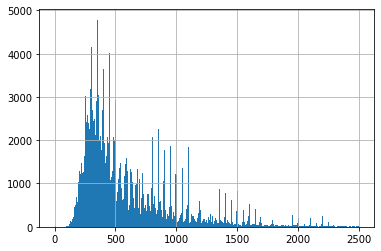

In [ ]:
# For visualization purposes | Base Rent Histogram
new_df = df_reduced[df_reduced['baseRent'] < 2500]
new_df['baseRent'].hist(bins=500)

In [ ]:
# Visualization Purposes
corr_df = df_reduced[df_reduced['yearConstructed'] > 1500]
corr_df = corr_df[corr_df['lastRefurbish'] < 2020]
corr_df = corr_df[corr_df['baseRent'] < 16000]
corr_df = corr_df[corr_df['noRooms'] < 25]
corr_df = corr_df[corr_df['livingSpace'] < 600]

corr_matrix = corr_df.corr()
corr_matrix['baseRent'].sort_values(ascending=False)

baseRent                    1.000000
baseRentRange               0.830428
livingSpace                 0.731814
livingSpaceRange            0.663571
noRooms                     0.471758
noRoomsRange                0.449485
pricetrend                  0.436458
picturecount                0.272989
totalRent                   0.267899
balcony                     0.265478
hasKitchen                  0.265139
lift                        0.251367
lastRefurbish               0.242426
geo_plz                     0.236819
yearConstructedRange        0.213471
newlyConst                  0.195043
heatingCosts                0.192765
serviceCharge               0.103628
yearConstructed             0.083249
scoutId                     0.081757
floor                       0.048623
cellar                      0.032506
garden                      0.025151
electricityBasePrice        0.024779
noParkSpaces                0.024711
telekomUploadSpeed          0.015820
numberOfFloors              0.009753
t

<IPython.core.display.Javascript object>


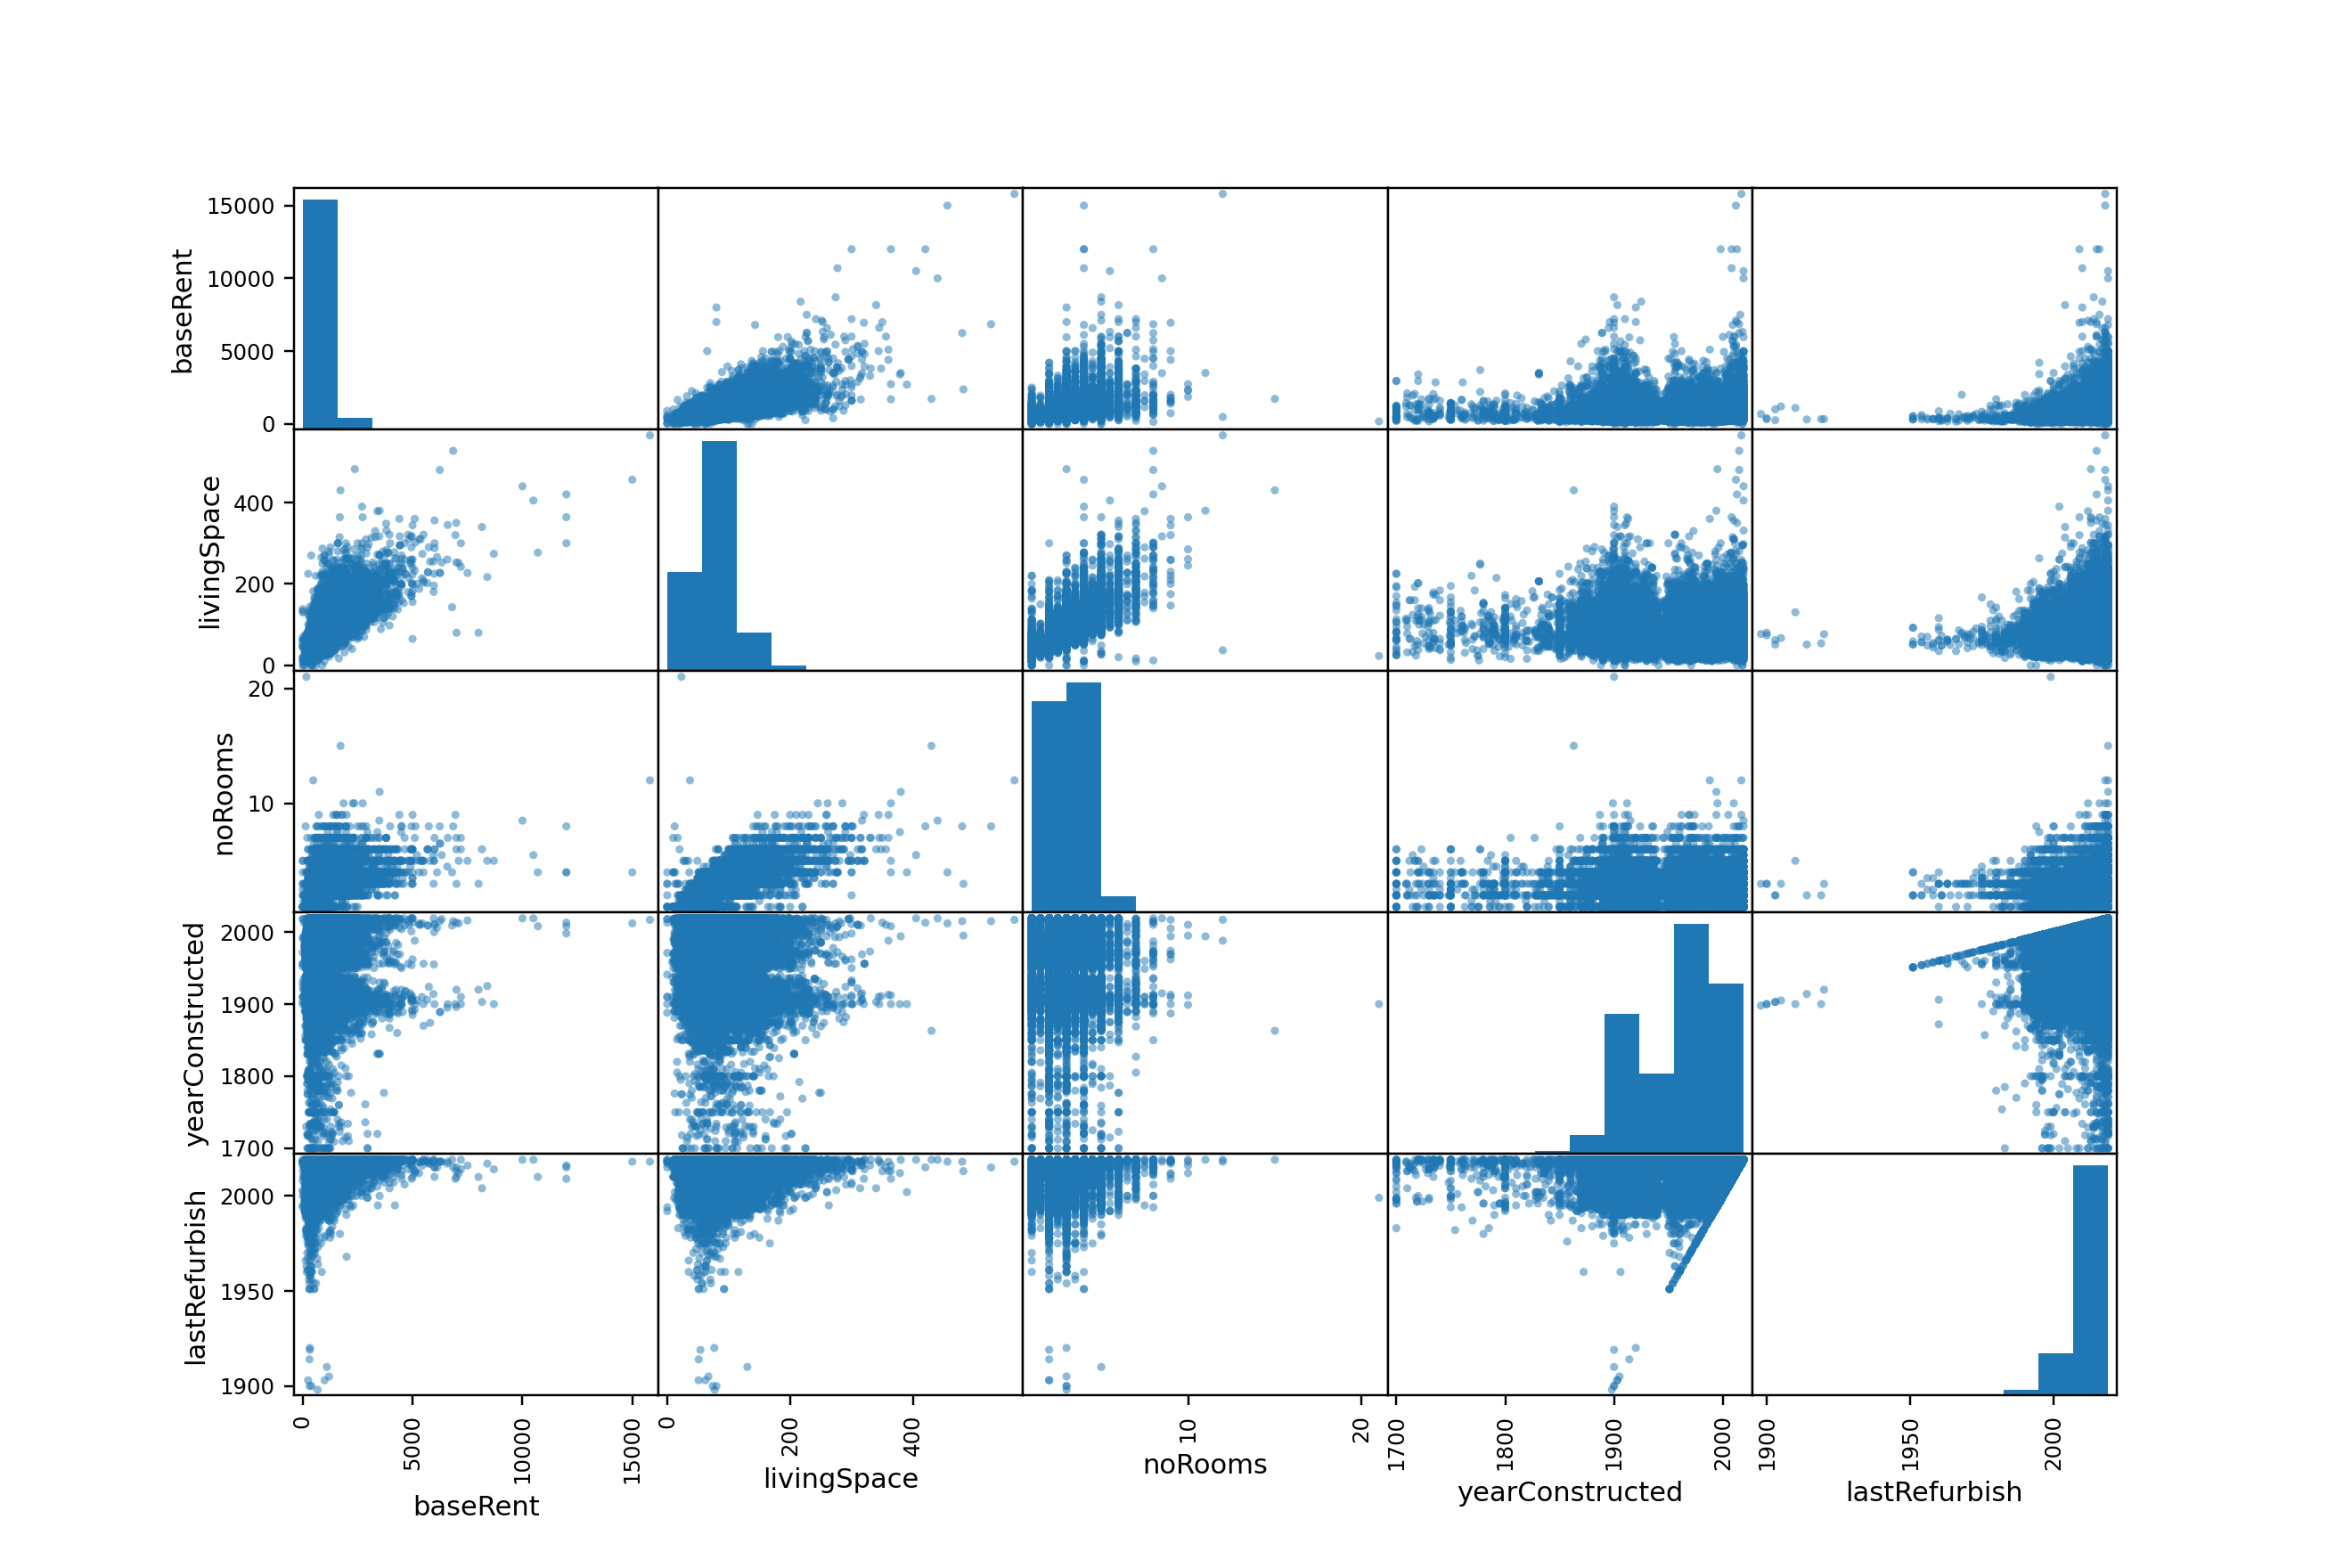

array([[<AxesSubplot:xlabel='baseRent', ylabel='baseRent'>,
        <AxesSubplot:xlabel='livingSpace', ylabel='baseRent'>,
        <AxesSubplot:xlabel='noRooms', ylabel='baseRent'>,
        <AxesSubplot:xlabel='yearConstructed', ylabel='baseRent'>,
        <AxesSubplot:xlabel='lastRefurbish', ylabel='baseRent'>],
       [<AxesSubplot:xlabel='baseRent', ylabel='livingSpace'>,
        <AxesSubplot:xlabel='livingSpace', ylabel='livingSpace'>,
        <AxesSubplot:xlabel='noRooms', ylabel='livingSpace'>,
        <AxesSubplot:xlabel='yearConstructed', ylabel='livingSpace'>,
        <AxesSubplot:xlabel='lastRefurbish', ylabel='livingSpace'>],
       [<AxesSubplot:xlabel='baseRent', ylabel='noRooms'>,
        <AxesSubplot:xlabel='livingSpace', ylabel='noRooms'>,
        <AxesSubplot:xlabel='noRooms', ylabel='noRooms'>,
        <AxesSubplot:xlabel='yearConstructed', ylabel='noRooms'>,
        <AxesSubplot:xlabel='lastRefurbish', ylabel='noRooms'>],
       [<AxesSubplot:xlabel='baseRent', ylabe

In [ ]:
attributes = ["baseRent", "livingSpace", "noRooms", "yearConstructed", "lastRefurbish"]
scatter_matrix(corr_df[attributes], figsize=(12, 8))

<IPython.core.display.Javascript object>


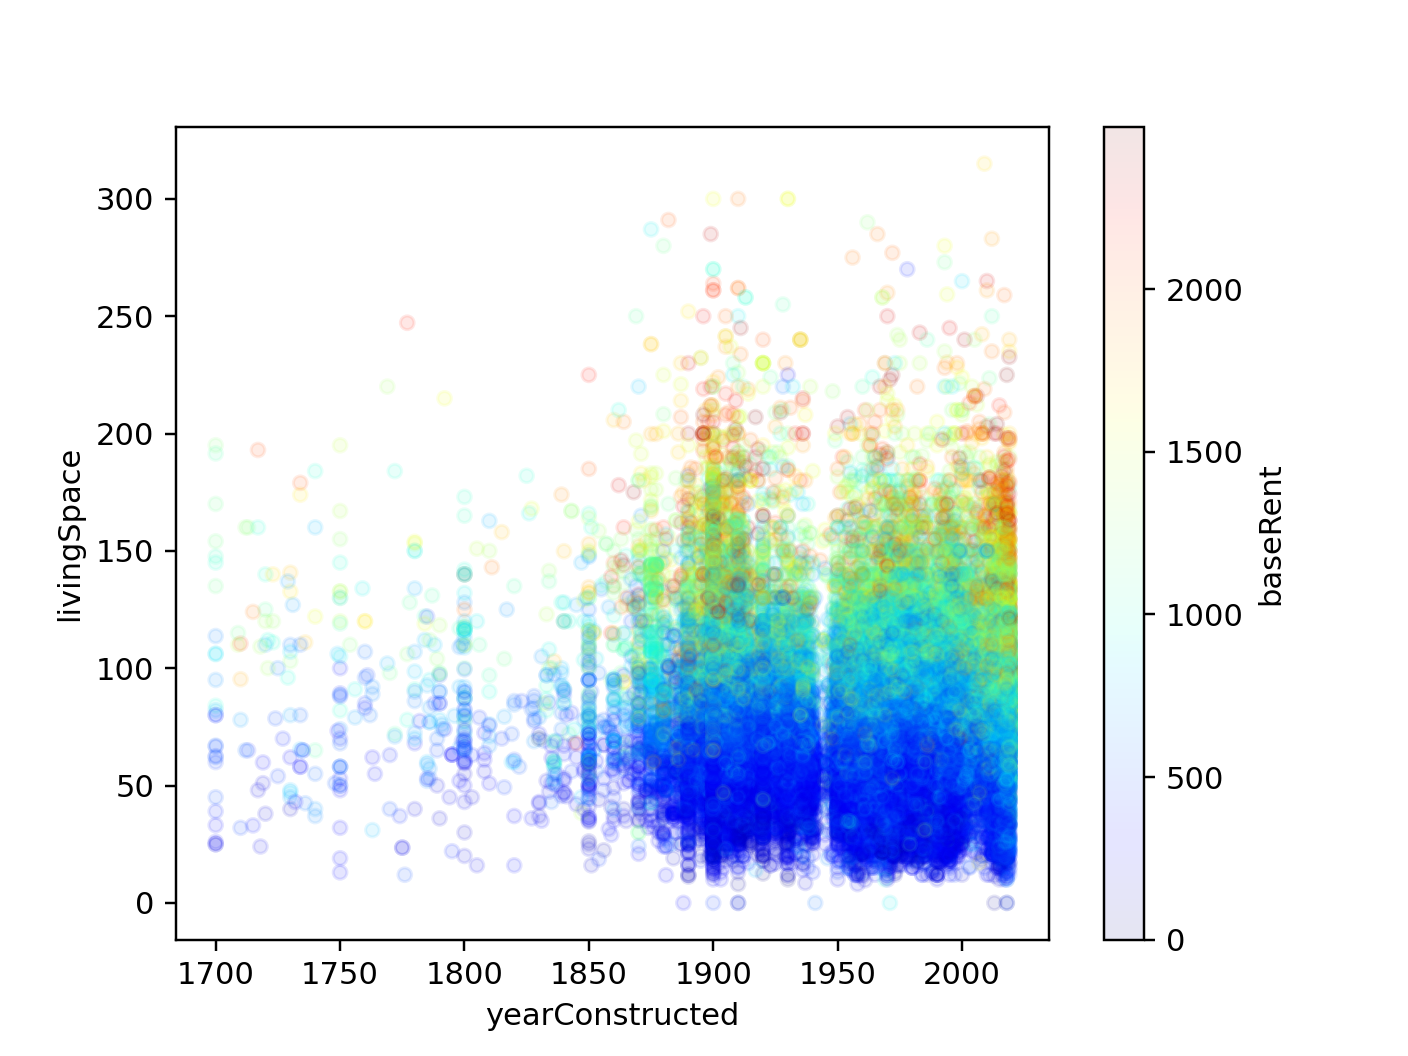

In [ ]:
new_df = corr_df[corr_df['baseRent'] < 2500]
new_df = new_df[new_df['livingSpace'] < 350]

new_df.plot(
   x='yearConstructed', 
   y='livingSpace', 
   kind='scatter',
   alpha = 0.1,
   c = 'baseRent',
   cmap = plt.get_cmap('jet'),
   colorbar = True
)

plt.show()

<IPython.core.display.Javascript object>


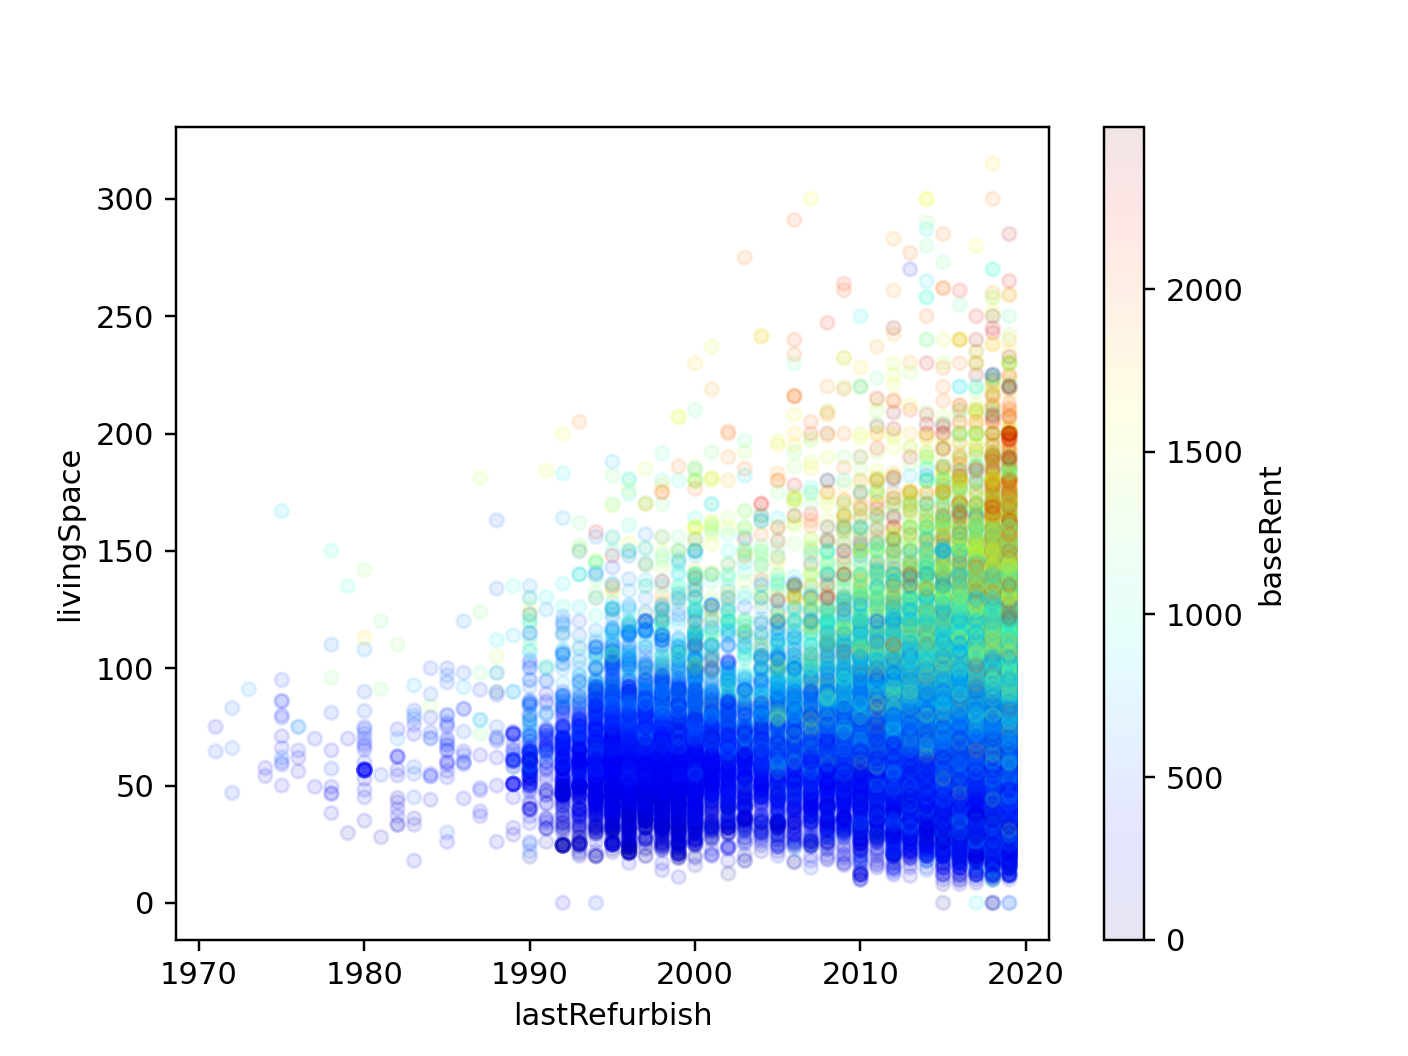

In [ ]:
new_df = corr_df[corr_df['baseRent'] < 2500]
new_df = new_df[new_df['livingSpace'] < 350]
new_df = new_df[new_df['lastRefurbish'] > 1970]
new_df = new_df[new_df['lastRefurbish'] < 2020]

new_df.plot(
   x='lastRefurbish', 
   y='livingSpace', 
   kind='scatter',
   alpha = 0.1,
   c = 'baseRent',
   cmap = plt.get_cmap('jet'),
   colorbar = True
)

plt.show()

<IPython.core.display.Javascript object>


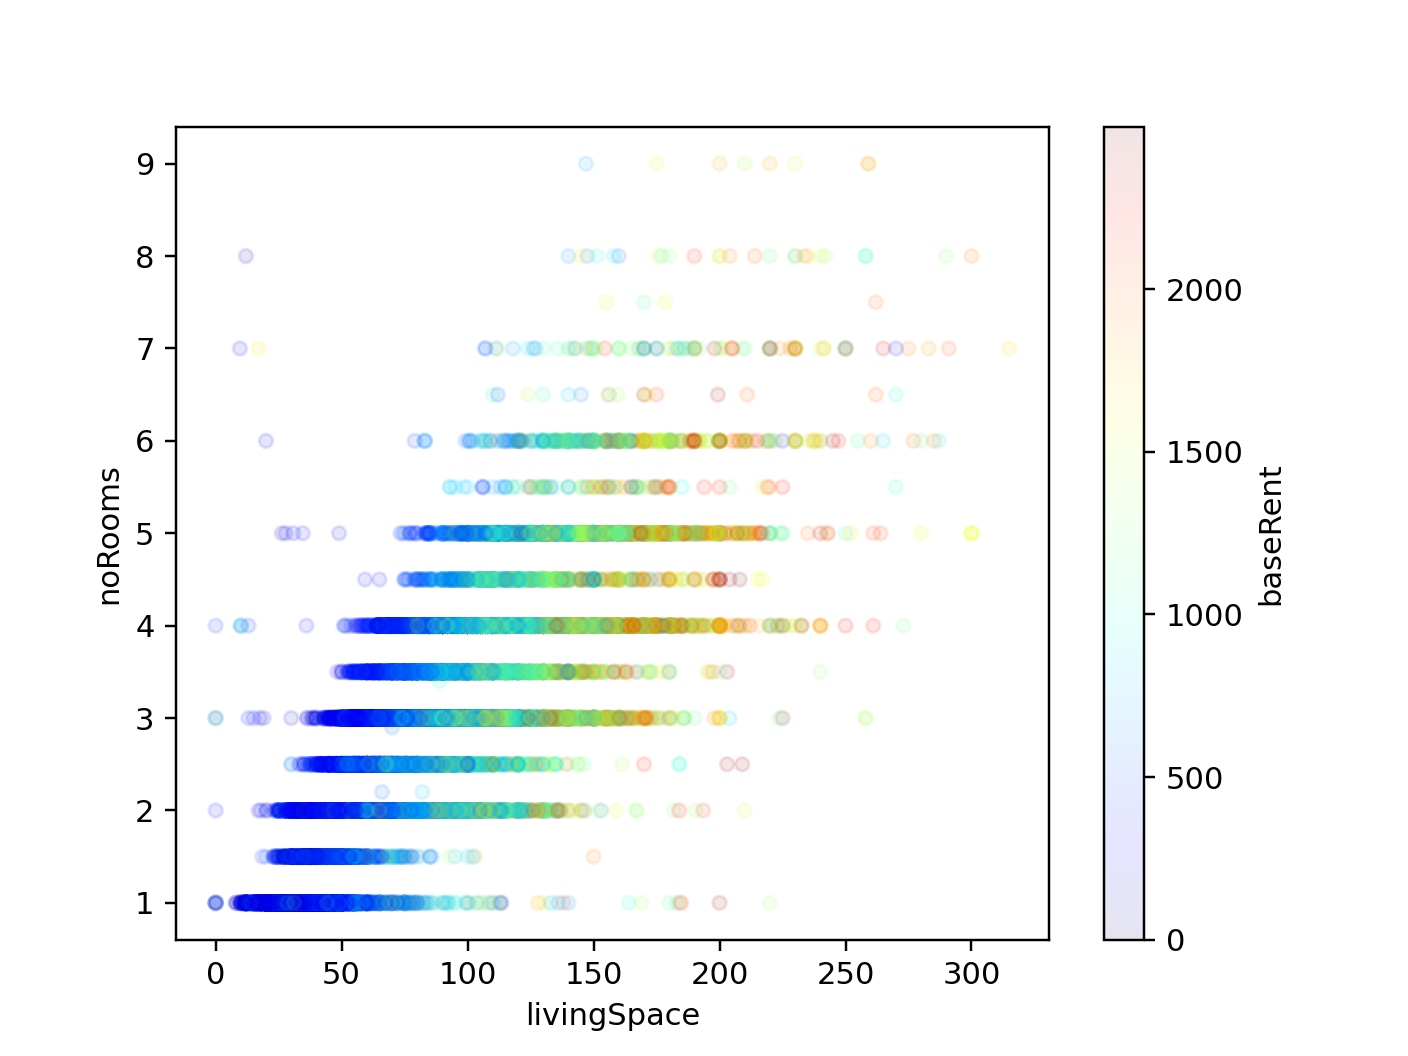

<AxesSubplot:xlabel='livingSpace', ylabel='noRooms'>

In [ ]:
new_df = corr_df[corr_df['baseRent'] < 2500]
new_df = new_df[new_df['noRooms'] < 10]
new_df = new_df[new_df['livingSpace'] < 350]

new_df.plot(
   y='noRooms', 
   x='livingSpace', 
   kind='scatter',
   alpha = 0.1,
   c = 'baseRent',
   cmap = plt.get_cmap('jet'),
   colorbar = True
)

In [ ]:
df.value_counts(df['houseNumber']) # we don't need the house number to predict prices

houseNumber
1        7173
2        6788
4        5823
3        5710
5        5518
         ... 
297b        1
299A        1
29B/C       1
29D         1
yy          1
Length: 5510, dtype: int64

In [ ]:
print(df.value_counts(df['livingSpace'])) # in sqm
index_names = df_reduced[ df_reduced['livingSpace'] > 3000 ].index # 7 entries 
df_reduced.drop(index_names, inplace = True)

livingSpace
60.00        5189
70.00        4154
80.00        4031
65.00        3808
75.00        3692
             ... 
128.51          1
128.52          1
128.57          1
128.60          1
111111.00       1
Length: 13005, dtype: int64


In [ ]:
df.value_counts(df['condition'])

condition
well_kept                             66591
refurbished                           26964
fully_renovated                       26368
first_time_use                        21959
mint_condition                        21938
modernized                            17226
first_time_use_after_refurbishment    15699
negotiable                             2240
need_of_renovation                     1372
ripe_for_demolition                       4
dtype: int64

In [ ]:
df.value_counts(df['interiorQual'])

interiorQual
normal           81826
sophisticated    64762
luxury            7648
simple            1949
dtype: int64

In [ ]:
df.value_counts(df['petsAllowed'])

petsAllowed
negotiable    91970
no            51991
yes           10316
dtype: int64

In [ ]:
# keep streetPlain and drop street 
df.value_counts(df['streetPlain'])

streetPlain
Hauptstraße                        911
Bahnhofstraße                      834
Leipziger_Straße                   428
Goethestraße                       406
Bahnhofstr.                        401
                                  ... 
Hohnsteiner_Straße                   1
Hohnstädter_Strasse                  1
Hohr                                 1
Hohwachter_Weg                       1
‪Friedrich-Karl-Klausing-Straße      1
Length: 54490, dtype: int64

In [ ]:
df.value_counts(df['baseRentRange']) # to much information gain for our predicted value

baseRentRange
2    54546
1    48225
5    38000
3    37138
7    27495
4    25808
6    24210
8     8251
9     5177
dtype: int64

In [ ]:
df.value_counts(df['typeOfFlat'])

typeOfFlat
apartment              131522
roof_storey             34787
ground_floor            31538
other                    9519
maisonette               9319
raised_ground_floor      5628
penthouse                3568
terraced_flat            3385
half_basement            2013
loft                      957
dtype: int64

In [ ]:
df.value_counts(df['geo_plz'])

geo_plz
9130     2008
9126     1994
9131     1649
9112     1626
9113     1416
         ... 
87754       1
87751       1
87748       1
87746       1
44177       1
Length: 7634, dtype: int64

In [ ]:
print(df.value_counts(df['noRooms']))
index_names = df_reduced[ df_reduced['noRooms'] > 50 ].index # 14 entries
df_reduced.drop(index_names, inplace = True)

noRooms
3.00      92089
2.00      89038
1.00      27805
4.00      27776
2.50       9583
          ...  
14.00         1
16.00         1
21.00         1
22.00         1
999.99        1
Length: 64, dtype: int64


In [ ]:
df.value_counts(df['energyEfficiencyClass']) # drop thermalChar since this is more insightful

energyEfficiencyClass
C                 14613
NO_INFORMATION    14130
D                 13925
B                 11333
E                  7987
A                  4988
F                  4484
A_PLUS             3618
G                  1806
H                   903
dtype: int64

In [ ]:
print(df.value_counts(df['floor']))
index_names = df_reduced[ df_reduced['floor'] > 63 ].index # germanys highest building has 63 floors
df_reduced.drop(index_names, inplace = True)

floor
 1.0      64133
 2.0      56937
 3.0      37879
 0.0      24604
 4.0      19953
 5.0       7987
 6.0       2493
 7.0       1031
 8.0        578
 9.0        427
 10.0       363
-1.0        314
 11.0       236
 12.0       144
 13.0       133
 14.0       110
 15.0        61
 16.0        34
 17.0        28
 19.0        15
 21.0        12
 18.0        11
 20.0        10
 80.0         6
 22.0         4
 24.0         3
 136.0        3
 23.0         2
 26.0         2
 29.0         2
 99.0         2
 98.0         2
 137.0        2
 133.0        1
 135.0        1
 645.0        1
 138.0        1
 139.0        1
 390.0        1
 650.0        1
 134.0        1
 25.0         1
 124.0        1
 105.0        1
 104.0        1
 83.0         1
 45.0         1
 41.0         1
 37.0         1
 36.0         1
 32.0         1
 31.0         1
 999.0        1
dtype: int64


In [ ]:
print(df.value_counts('numberOfFloors'))
index_names = df_reduced[ df_reduced['numberOfFloors'] > 63 ].index # germanys highest building has 63 floors
df_reduced.drop(index_names, inplace = True)

numberOfFloors
3.0      50822
4.0      39862
2.0      37350
5.0      19833
1.0       8463
6.0       6282
7.0       2555
0.0       1371
8.0       1133
11.0      1004
10.0       572
9.0        514
14.0       239
12.0       195
16.0       170
13.0       169
15.0       122
17.0       103
18.0        73
20.0        65
19.0        55
23.0        29
21.0        28
22.0        25
40.0        12
26.0         7
27.0         6
31.0         5
24.0         5
33.0         4
45.0         3
36.0         3
34.0         3
999.0        3
25.0         3
30.0         3
32.0         2
800.0        2
99.0         2
28.0         2
43.0         2
42.0         2
378.0        1
29.0         1
730.0        1
600.0        1
594.0        1
410.0        1
400.0        1
370.0        1
54.0         1
301.0        1
252.0        1
41.0         1
92.0         1
90.0         1
200.0        1
dtype: int64


In [ ]:
df.value_counts(df['noRoomsRange']) # Drop too much info

noRoomsRange
3    100992
2     98728
1     31218
4     29851
5      8061
dtype: int64

In [ ]:
df.value_counts(df['livingSpaceRange']) # range based on the living space -> Drop column

livingSpaceRange
3    82458
2    76383
4    42789
1    27057
5    20523
6    12866
7     6774
dtype: int64

In [ ]:
print(df.value_counts(df['heatingCosts']))
index_names = df_reduced[ df_reduced['heatingCosts'] > 9000 ].index # 11 entries total rent is lower than heating cost?
df_reduced.drop(index_names, inplace = True)

heatingCosts
60.00       5310
70.00       4811
80.00       4763
50.00       4286
100.00      3970
            ... 
70.88          1
70.91          1
70.92          1
70.95          1
12613.00       1
Length: 5669, dtype: int64


In [ ]:
print(df.value_counts(df['lastRefurbish']))
index_names = df_reduced[ df_reduced['lastRefurbish'] < 1100].index # 1 value 
df_reduced.drop(index_names, inplace = True)

lastRefurbish
2019.0    20202
2018.0    13206
2017.0     7111
2016.0     5679
2015.0     4638
          ...  
1957.0        1
1964.0        1
1965.0        1
1973.0        1
1015.0        1
Length: 88, dtype: int64


In [ ]:
df.value_counts(df['electricityBasePrice']) # useless drop electricityBasePrice

electricityBasePrice
90.76    42856
71.43     3990
dtype: int64

In [ ]:
df.value_counts(df['electricityKwhPrice'])

electricityKwhPrice
0.1985    14639
0.2055    13076
0.1915    10114
0.1845     2952
0.2276     1411
0.2125      727
0.2074      705
0.1775      676
0.2205      662
0.2137      450
0.2132      404
0.2144      358
0.1705      240
0.2195      239
0.2265      193
dtype: int64

In [ ]:
df.value_counts(df['date'])

date
Feb20    79276
May19    76047
Oct19    66685
Sep18    46842
dtype: int64

In [32]:
df_date = df.groupby('date').mean()
df_date = df_date.reindex(['Sep18','May19','Oct19','Feb20'])
df_date.plot.line(y='baseRent')
print(df_date['baseRent'])

<IPython.core.display.Javascript object>

date
Sep18    673.566529
May19    645.645441
Oct19    661.523788
Feb20    780.215725
Name: baseRent, dtype: float64


In [33]:
only_date = df_date.iloc[:,14]
only_date.iloc[0:1]

date
Sep18    673.566529
Name: baseRent, dtype: float64

In [34]:
only_date.iloc[0:1][0]

673.5665287562443

In [35]:
def date_stats(date):
    if date == 'Sep18':
        return only_date.iloc[0:1][0]
    elif date == 'May19':
        return only_date.iloc[1:2][0]
    elif date == 'Oct19':
        return only_date.iloc[2:3][0]
    elif date == 'Feb20':
        return only_date.iloc[3:4][0]


df_average_rent = df.copy()
df_average_rent['average_rent'] = df['date'].map(date_stats)
df_average_rent.drop('date',axis=1,inplace=True)
df_average_rent

regio1  serviceCharge                     heatingType  \
0       Nordrhein_Westfalen         245.00                 central_heating   
1           Rheinland_Pfalz         134.00  self_contained_central_heating   
2                   Sachsen         255.00                   floor_heating   
3                   Sachsen          58.15                district_heating   
4                    Bremen         138.00  self_contained_central_heating   
...                     ...            ...                             ...   
268845               Bayern          90.00                       heat_pump   
268846               Hessen         220.00                     gas_heating   
268847               Hessen         220.00                 central_heating   
268848  Nordrhein_Westfalen         175.00                       heat_pump   
268849               Hessen         315.00                 central_heating   

       telekomTvOffer  telekomHybridUploadSpeed  newlyConst  balcony  \
0       ONE_YEAR_FREE                       NaN       False    False   
1       ONE_YEAR_FREE                       NaN       False     True   
2       ONE_YEAR_FREE                      10.0        True     True   
3       ONE_YEAR_FREE                       NaN       False     True   
4                 NaN                       NaN       False     True   
...               ...                       ...         ...      ...   
268845  ONE_YEAR_FREE                       NaN       False     True   
268846            NaN                       NaN       False     True   
268847  ONE_YEAR_FREE                       NaN       False     True   
268848            NaN                       NaN        True     True   
268849            NaN                       NaN       False     True   

        picturecount  pricetrend  telekomUploadSpeed  totalRent  \
0                  6        4.62                10.0      840.0   
1                  8        3.47                10.0        NaN   
2                  8        2.72                 2.4     1300.0   
3                  9        1.53                40.0        NaN   
4                 19        2.46                 NaN      903.0   
...              ...         ...                 ...        ...   
268845             0        2.74                10.0      910.0   
268846            12        6.49                 NaN     1150.0   
268847            21        2.90                40.0      930.0   
268848            16        4.39                 NaN     1015.0   
268849             9        5.00                 NaN        NaN   

        yearConstructed    scoutId  noParkSpaces       firingTypes  \
0                1965.0   96107057           1.0               oil   
1                1871.0  111378734           2.0               gas   
2                2019.0  113147523           1.0               NaN   
3                1964.0  108890903           NaN  district_heating   
4                1950.0  114751222           NaN               gas   
...                 ...        ...           ...               ...   
268845           2016.0  115641081           1.0        geothermal   
268846           1983.0   96981497           1.0               gas   
268847           1965.0   66924271           1.0               gas   
268848           2019.0  110938302           1.0               gas   
268849           1972.0  115524054           1.0  district_heating   

        hasKitchen              geo_bln  cellar  yearConstructedRange  \
0            False  Nordrhein_Westfalen    True                   2.0   
1            False      Rheinland_Pfalz   False                   1.0   
2            False              Sachsen    True                   9.0   
3            False              Sachsen   False                   2.0   
4            False               Bremen   False                   1.0   
...            ...                  ...     ...                   ...   
268845       False               Bayern    True               

In [36]:
# This might be useful later
rent_to_date = {673.5665287562443 : 'Sep18', 645.645441108788 : 'May19',
                661.5237879583115 : 'Oct19', 780.2157248095261 : 'Feb20' } 

## Final Data Cleaning

In [ ]:
# drop scoutId -> immoscout id no information gain TODO: show no correlation 
# DROP: telekomHybridUploadSpeed, electricityBasePrice, electricityKwhPrice, description, facilities, scoutId, 
#       geo_bln, geo_krs, houseNumber, street, thermalChar, electricityBasePrice, telekomTvOffer, baseRentRange, 
#       telekomUploadSpeed, yearConstructedRange, livingSpaceRange, noRoomsRange 

# 49 - 19 = 30

In [ ]:
# Train, Validation, and Test Sets
train_set, test_set = train_test_split(df, test_size=0.15, random_state=123)
train_set, valid_set = train_test_split(train_set, test_size=0.10, random_state=123)

In [13]:
def preprocess(df_in):
    
    df = df_in.copy() 
    
    df = df.drop(columns=[
        'telekomHybridUploadSpeed', 
        'electricityBasePrice', 
        'electricityKwhPrice', 
        'description', 
        'facilities',
        'scoutId',
        'geo_bln',
        'geo_krs',
        'houseNumber',
        'street',
        'streetPlain', #this is temporary, just for poly regression
        'thermalChar',
        'electricityBasePrice',
        'totalRent',
        'baseRentRange',
        'telekomTvOffer',
        'yearConstructedRange',
        'telekomUploadSpeed',
        'livingSpaceRange',
        'noRoomsRange'
    ])
    

    # Numerical Values 
    df['serviceCharge'].fillna(df.serviceCharge.mean(),inplace=True)
    df['pricetrend'].fillna(df.pricetrend.mean(), inplace=True)
    df['yearConstructed'].fillna(df.yearConstructed.mean(), inplace=True)
    df['noParkSpaces'].fillna(df.noParkSpaces.median(), inplace=True) #median since its exactly 1
    df['floor'].fillna(df.floor.median(), inplace=True)
    df['numberOfFloors'].fillna(df.numberOfFloors.median(), inplace=True)
    df['heatingCosts'].fillna(df.heatingCosts.mean(), inplace=True)
    df['lastRefurbish'].fillna(df.lastRefurbish.median(), inplace=True)


    # Categorical Values
    df['heatingType'].fillna('central_heating', inplace=True)
    df['firingTypes'].fillna('gas', inplace=True)
    df['condition'].fillna('well-kept', inplace=True)
    df['interiorQual'].fillna('normal', inplace=True)
    df['petsAllowed'].fillna('negotiable', inplace=True)
    #df['streetPlain'].fillna('unknown', inplace=True)
    df['typeOfFlat'].fillna('apartment', inplace=True)
    df['energyEfficiencyClass'].fillna('NO_INFORMATION', inplace=True)

    
    # Transform boolean to integer
    df['newlyConst'] = df['newlyConst'].apply(int)           
    df['balcony'] = df['balcony'].apply(int)           
    df['hasKitchen'] = df['hasKitchen'].apply(int)           
    df['cellar'] = df['cellar'].apply(int)    
    df['lift'] = df['lift'].apply(int)           
    df['garden'] = df['garden'].apply(int)    


    # Deleting outliers
    index_names = df[ df['yearConstructed'] > 2022 ].index
    df.drop(index_names, inplace = True)

    index_names = df[ df['yearConstructed'] < 1700 ].index
    df.drop(index_names, inplace = True)  

    df = df[df['noParkSpaces'] < 50]
    df = df[df['noRooms'] < 50]
    df = df[ df['heatingCosts'] < 9000]
    df = df[ df['baseRent'] < 16000 ]
    df = df[ df['floor'] < 63 ]
    df = df[ df['numberOfFloors'] < 63 ] 

    
    X = df.drop('baseRent', axis=1)
    y = df['baseRent'].copy()
    
    return(X,y)

In [14]:
# Preprocess Data
X_train, y_train = preprocess(train_set)
X_valid, y_valid = preprocess(valid_set)
X_test, y_test = preprocess(test_set)

# Fit Data
num_attribs = list(X_train.select_dtypes('number'))
cat_attribs = list(X_train.select_dtypes('object'))


pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attribs),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)
])

X_train_prepared = pipeline.fit_transform(X_train)
X_valid_prepared = pipeline.transform(X_valid)
X_test_prepared = pipeline.transform(X_test)


### Predict - Linear Regression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
lin_reg.intercept_, lin_reg.coef_
print("Score: ",lin_reg.score(X_train_prepared,y_train))

predict = lin_reg.predict(X_train_prepared)

print("Mean Square Error: ", mean_squared_error(y_train, predict))
print("Root Mean Squared Error ", sqrt(mean_squared_error(y_train,predict)))
print("Mean Absolute Error ", mean_absolute_error(y_train,predict))
print("Mean Absolute Percentage Error ", mean_absolute_percentage_error(y_train,predict))

Score:  0.980159702519244
Mean Square Error:  9895311.772684256
Root Mean Squared Error  3145.6814480624475
Mean Absolute Error  154.98396552391233
Mean Absolute Percentage Error  249501670025080.88


--------

### Predict - Polynomial Regression

In [16]:
X_red = X_train_prepared[0:1000,:]
y_red = y_train[0:1000]

In [17]:

poly_lin_mod = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("linear", LinearRegression())
    ])

start = datetime.now()

poly_lin_mod.fit(X_red, y_red)
score = cross_validate(poly_lin_mod, X_red, y_red, cv=3)

predict = poly_lin_mod.predict(X_train_prepared)
end = datetime.now()
print("Score: ",poly_lin_mod.score(X_train_prepared,y_train))
print("Mean Square Error: ", mean_squared_error(y_train, predict))
print("Root Mean Squared Error ", sqrt(mean_squared_error(y_train,predict)))
print("Mean Absolute Error ", mean_absolute_error(y_train,predict))
print("Mean Absolute Percentage Error ", mean_absolute_percentage_error(y_train,predict))
print("---------------------")
print("Elapsed", (end - start).total_seconds(), "seconds")

Score:  -1581.306232973515
Mean Square Error:  394845278.1974279
Root Mean Squared Error  19870.714083732066
Mean Absolute Error  235.48975377085836
Mean Absolute Percentage Error  965007718453070.0
---------------------
Elapsed 577.813756 seconds


Validation 

In [29]:
predict = poly_lin_mod.predict(X_valid_prepared)
print("Mean Square Error: ", mean_squared_error(y_valid, predict))
print("Root Mean Squared Error ", sqrt(mean_squared_error(y_valid,predict)))
print("Mean Absolute Error ", mean_absolute_error(y_valid,predict))
print("Mean Absolute Percentage Error ", mean_absolute_percentage_error(y_valid,predict))

Mean Square Error:  585677.0028450886
Root Mean Squared Error  765.2953696744079
Mean Absolute Error  180.35670108692005
Mean Absolute Percentage Error  519258662511677.8


In [25]:
for key,val in score.items():
    total = np.mean(val)
    print(key,total)

fit_time 129.77995570500693
score_time 0.01312708854675293
test_score 0.6014693207484122


-----------------------------------

### Predict - Random Forest

In [ ]:
X_red = X_train_prepared[0:100,:]
y_red = y_train[0:100]

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_19078/2284947527.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_red = y_train[0:100]


In [ ]:
rf_reg = RandomForestRegressor(n_estimators=50, max_features=5)
est = rf_reg.fit(X_red, y_red)

price_predictions = est.predict(X_valid_prepared)
randomforest_rmse = np.sqrt(mean_squared_error(y_valid, price_predictions))
print('mean squared error: ', mean_squared_error(y_valid, price_predictions))
print('Root mean squared error: ', randomforest_rmse)
print('mean absolute error: ', mean_absolute_error(y_valid, price_predictions))
print('mean absolute percentage error: ', mean_absolute_percentage_error(y_valid, price_predictions))

mean squared error:  152744.75985454628
Root mean squared error:  390.8257410337071
mean absolute error:  243.4363626402223
mean absolute percentage error:  887198737446313.1


#### Permutation Importance for the Random Forest

In [ ]:
data = permutation_importance(est, X_red.toarray(), y_red,  random_state = 42)

In [ ]:
sorted_idx = data.importances_mean.argsort()[::-1]

In [ ]:
pipeline.transformers[1][1].fit(X_train.select_dtypes('object'))

all_attributes = np.concatenate((
    X_train.select_dtypes('number').columns.to_numpy(),
    pipeline.transformers[1][1].get_feature_names()
))

/opt/anaconda3/envs/ADS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>


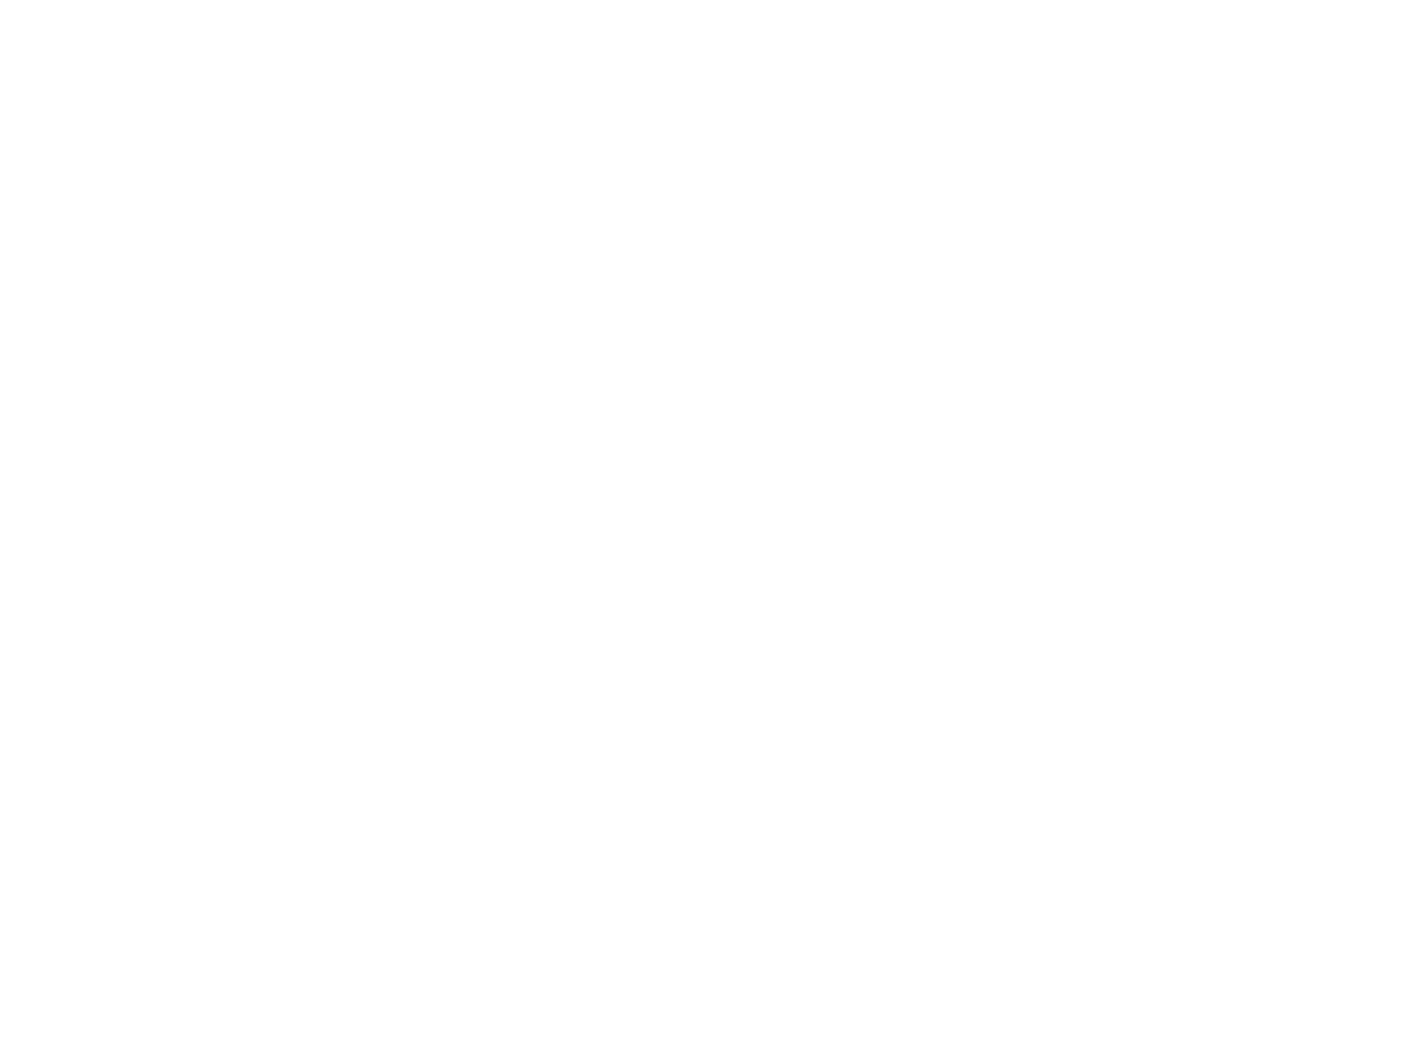

<IPython.core.display.Javascript object>


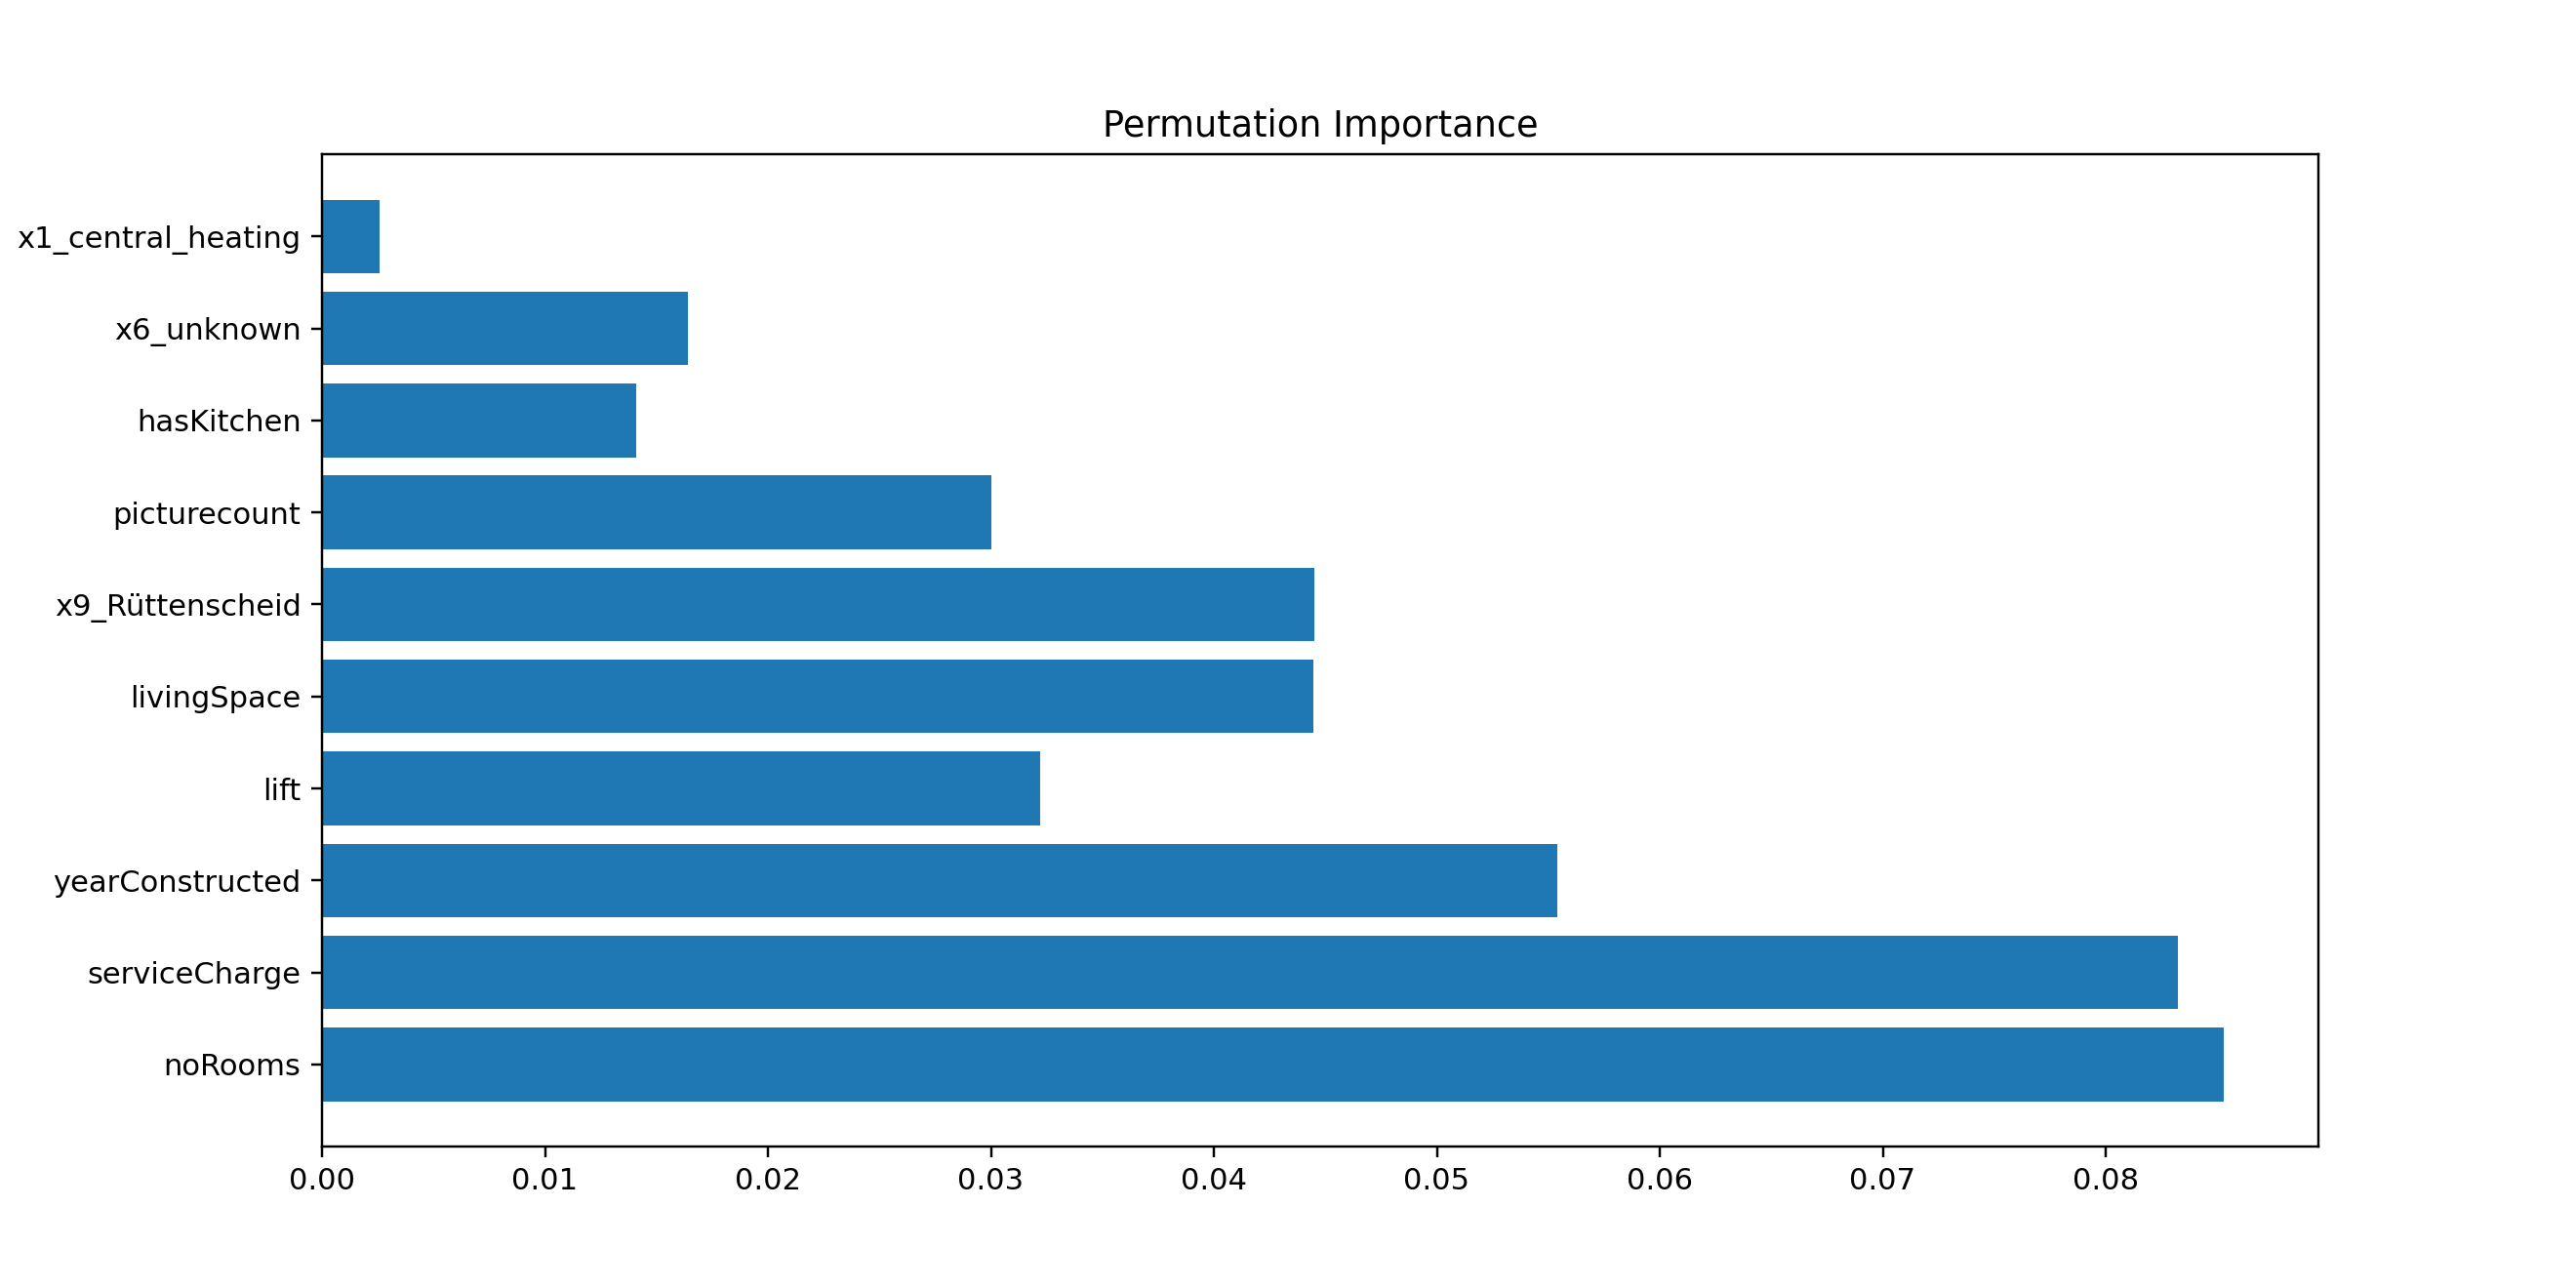

In [ ]:
sorted_idx = data.importances_mean.argsort()[::-1]
#print(result.importances_mean[sorted_idx])

plt.clf()
fig = plt.figure(figsize=(12, 6))
plt.barh(all_attributes[sorted_idx][:10], est.feature_importances_[sorted_idx][:10], align='center')
plt.title('Permutation Importance')
plt.show()

#### Partial Dependency Plot Random Forest with yearConstructed and livingSpace

/opt/anaconda3/envs/ADS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>


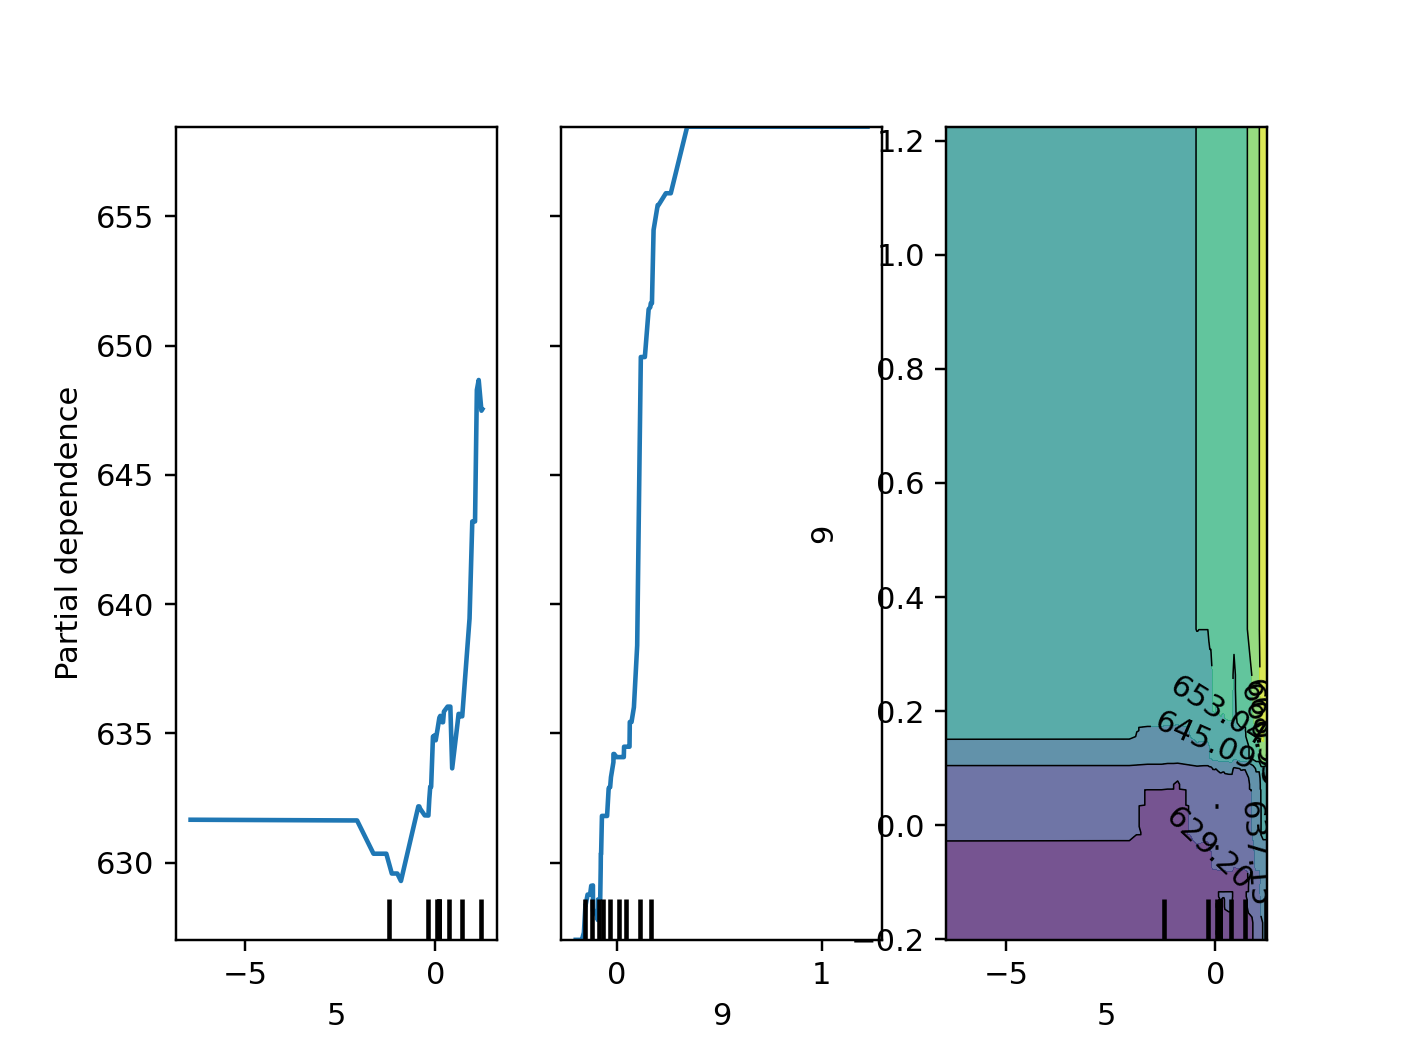

In [ ]:
disp1 = plot_partial_dependence(est, X_red.toarray(),[5, 9,(5,9)]) 

--------

### Predict - Neural Network

In [ ]:
X_train_prepared = X_train_prepared.toarray()
X_valid_prepared = X_valid_prepared.toarray()
X_test_prepared = X_test_prepared.toarray()

type(X_train_prepared)

numpy.ndarray

In [ ]:
model = keras.models.Sequential()
input_ = keras.layers.Input(shape=X_train_prepared.shape[1:])
hidden1 = keras.layers.Dense(60,activation="relu")(input_)
hidden2 = keras.layers.Dense(60,activation="relu")(hidden1)
hidden3 = keras.layers.Dense(60,activation="relu")(hidden2)
concat = keras.layers.concatenate([input_, hidden2, hidden3])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_],outputs=[output])

model.compile(loss="mean_absolute_error", optimizer=keras.optimizers.Adam(learning_rate=1e-2))
history = model.fit(X_train_prepared, y_train, epochs=20, validation_data=(X_valid_prepared, y_valid))

Epoch 1/20
6428/6428 [==============================] - 249s 39ms/step - loss: 172.0917 - val_loss: 91.8650
Epoch 2/20
6428/6428 [==============================] - 246s 38ms/step - loss: 148.9515 - val_loss: 89.1521
Epoch 3/20
6428/6428 [==============================] - 233s 36ms/step - loss: 133.7457 - val_loss: 85.7639
Epoch 4/20
6428/6428 [==============================] - 234s 36ms/step - loss: 127.4598 - val_loss: 86.5884
Epoch 5/20
6428/6428 [==============================] - 235s 37ms/step - loss: 123.5878 - val_loss: 83.1200
Epoch 6/20
6428/6428 [==============================] - 234s 36ms/step - loss: 119.6969 - val_loss: 82.4234
Epoch 7/20
6428/6428 [==============================] - 235s 37ms/step - loss: 116.5824 - val_loss: 81.3572
Epoch 8/20
6428/6428 [==============================] - 234s 36ms/step - loss: 114.0659 - val_loss: 84.1908
Epoch 9/20
6428/6428 [==============================] - 236s 37ms/step - loss: 112.4309 - val_loss: 82.6875
Epoch 10/20
6428/6428 [=====

In [ ]:
model.evaluate(X_test_prepared,y_test)

1261/1261 [==============================] - 11s 9ms/step - loss: 75.2394


75.2394027709961

In [ ]:
#268850
#1000
X_red_train = X_train_prepared[0:1000,:]
y_red_train = y_train[0:1000]

X_red_valid = X_valid_prepared[0:1000,:]
y_red_valid = y_valid[0:1000]

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_19078/1895940810.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_red_train = y_train[0:1000]
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_19078/1895940810.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_red_valid = y_valid[0:1000]


In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-2, input_shape=[55469]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_absolute_error", optimizer=optimizer)
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_19078/1758918061.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [ ]:
param_distribs = {
    "n_hidden": [ 1, 2, 3],
    "n_neurons": np.arange(20, 60).tolist(),
    "learning_rate": reciprocal(1e-2, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=2, verbose=2)
rnd_search_cv.fit(X_red_train, y_red_train, epochs=20,
                  validation_data=(X_red_valid, y_red_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Epoch 1/20
16/16 [==============================] - 2s 67ms/step - loss: 623.6061 - val_loss: 590.8931
Epoch 2/20
16/16 [==============================] - 1s 36ms/step - loss: 570.2693 - val_loss: 509.7789
Epoch 3/20
16/16 [==============================] - 1s 34ms/step - loss: 450.7345 - val_loss: 361.3658
Epoch 4/20
16/16 [==============================] - 1s 35ms/step - loss: 299.3816 - val_loss: 244.8957
Epoch 5/20
16/16 [==============================] - 1s 35ms/step - loss: 223.3235 - val_loss: 201.4056
Epoch 6/20
16/16 [==============================] - 1s 34ms/step - loss: 182.0284 - val_loss: 184.3470
Epoch 7/20
16/16 [==============================] - 1s 34ms/step - loss: 159.3447 - val_loss: 174.2284
Epoch 8/20
16/16 [==============================] - 1s 34ms/step - loss: 145.3253 - val_loss: 170.2066
Epoch 9/20
16/16 [==============================] - 1s 34ms/step - loss: 132.2808 - val_loss: 164.6046
Epoch 10/20


16/16 [==============================] - 0s 26ms/step - loss: 40.4833 - val_loss: 143.9156
Epoch 16/20
16/16 [==============================] - 0s 30ms/step - loss: 38.3110 - val_loss: 140.1892
Epoch 17/20
16/16 [==============================] - 0s 32ms/step - loss: 36.7508 - val_loss: 140.9560
Epoch 18/20
16/16 [==============================] - 0s 31ms/step - loss: 38.4007 - val_loss: 143.4327
Epoch 19/20
16/16 [==============================] - 1s 33ms/step - loss: 34.4055 - val_loss: 140.8838
Epoch 20/20
16/16 [==============================] - 0s 5ms/step - loss: 136.8591
[CV] END learning_rate=0.015954676534032302, n_hidden=2, n_neurons=42; total time=  12.1s
Epoch 1/20
16/16 [==============================] - 1s 36ms/step - loss: 630.1594 - val_loss: 610.9855
Epoch 2/20
16/16 [==============================] - 0s 27ms/step - loss: 617.9329 - val_loss: 594.0719
Epoch 3/20
16/16 [==============================] - 0s 29ms/step - loss: 593.4139 - val_loss: 563.3498
Epoch 4/20
16/16

16/16 [==============================] - 1s 37ms/step - loss: 69.0140 - val_loss: 143.0147
Epoch 9/20
16/16 [==============================] - 1s 35ms/step - loss: 66.3510 - val_loss: 142.4728
Epoch 10/20
16/16 [==============================] - 1s 36ms/step - loss: 59.6894 - val_loss: 141.3874
Epoch 11/20
16/16 [==============================] - 1s 37ms/step - loss: 55.7669 - val_loss: 147.6810
Epoch 12/20
16/16 [==============================] - 1s 37ms/step - loss: 51.9597 - val_loss: 138.8736
Epoch 13/20
16/16 [==============================] - 1s 37ms/step - loss: 46.1017 - val_loss: 148.9328
Epoch 14/20
16/16 [==============================] - 1s 36ms/step - loss: 50.6249 - val_loss: 141.9379
Epoch 15/20
16/16 [==============================] - 1s 36ms/step - loss: 47.5976 - val_loss: 141.9485
Epoch 16/20
16/16 [==============================] - 1s 37ms/step - loss: 42.8991 - val_loss: 139.0847
Epoch 17/20
16/16 [==============================] - 1s 37ms/step - loss: 41.7168 - va

16/16 [==============================] - 2s 44ms/step - loss: 518.5244 - val_loss: 286.6585
Epoch 2/20
16/16 [==============================] - 1s 34ms/step - loss: 241.6797 - val_loss: 182.4042
Epoch 3/20
16/16 [==============================] - 1s 35ms/step - loss: 163.2906 - val_loss: 163.4034
Epoch 4/20
16/16 [==============================] - 1s 34ms/step - loss: 122.1101 - val_loss: 149.3796
Epoch 5/20
16/16 [==============================] - 1s 34ms/step - loss: 97.3814 - val_loss: 146.0502
Epoch 6/20
16/16 [==============================] - 1s 34ms/step - loss: 84.7220 - val_loss: 154.2749
Epoch 7/20
16/16 [==============================] - 1s 33ms/step - loss: 80.0224 - val_loss: 142.5849
Epoch 8/20
16/16 [==============================] - 1s 35ms/step - loss: 67.0409 - val_loss: 141.9570
Epoch 9/20
16/16 [==============================] - 1s 35ms/step - loss: 58.1992 - val_loss: 144.5979
Epoch 10/20
16/16 [==============================] - 1s 34ms/step - loss: 55.4598 - val_l

16/16 [==============================] - 1s 36ms/step - loss: 49.1588 - val_loss: 150.2328
Epoch 17/20
16/16 [==============================] - 1s 37ms/step - loss: 42.5979 - val_loss: 149.5317
Epoch 18/20
16/16 [==============================] - 1s 37ms/step - loss: 37.6773 - val_loss: 148.0203
Epoch 19/20
16/16 [==============================] - 0s 5ms/step - loss: 146.4808
[CV] END learning_rate=0.015547779633863055, n_hidden=3, n_neurons=48; total time=  11.9s
Epoch 1/20
16/16 [==============================] - 2s 49ms/step - loss: 506.5189 - val_loss: 396.8051
Epoch 2/20
16/16 [==============================] - 1s 35ms/step - loss: 254.3617 - val_loss: 196.8072
Epoch 3/20
16/16 [==============================] - 1s 36ms/step - loss: 165.1173 - val_loss: 160.5186
Epoch 4/20
16/16 [==============================] - 1s 35ms/step - loss: 122.2447 - val_loss: 149.2126
Epoch 5/20
16/16 [==============================] - 1s 36ms/step - loss: 99.3430 - val_loss: 151.2830
Epoch 6/20
16/16 

16/16 [==============================] - 1s 47ms/step - loss: 72.9533 - val_loss: 150.7407
Epoch 11/20
16/16 [==============================] - 1s 45ms/step - loss: 63.6565 - val_loss: 150.5725
Epoch 12/20
16/16 [==============================] - 1s 48ms/step - loss: 57.0402 - val_loss: 148.4571
Epoch 13/20
16/16 [==============================] - 1s 47ms/step - loss: 50.8549 - val_loss: 147.8297
Epoch 14/20
16/16 [==============================] - 1s 47ms/step - loss: 45.9594 - val_loss: 148.2219
Epoch 15/20
16/16 [==============================] - 1s 47ms/step - loss: 43.2669 - val_loss: 147.3813
Epoch 16/20
16/16 [==============================] - 1s 46ms/step - loss: 37.2152 - val_loss: 147.5040
Epoch 17/20
16/16 [==============================] - 1s 48ms/step - loss: 36.9207 - val_loss: 147.0397
Epoch 18/20
16/16 [==============================] - 1s 47ms/step - loss: 34.5201 - val_loss: 146.5530
Epoch 19/20
16/16 [==============================] - 1s 45ms/step - loss: 34.1472 - v

RandomizedSearchCV(cv=2,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc3080392d0>,
                   param_distributions={'learning_rate': [0.014926880695072052,
                                                          0.010277487103982668,
                                                          0.02146255983979274,
                                                          0.02946921031205021,
                                                          0.01580801087934011,
                                                          0.029450680362079058,
                                                          0.017621422471114544,
                                                          0.012035052929974081,
                                                          0.011139719456023083,
                                                          0.01494854334003824,
                                                          0.018...
                                                          0.010890899235549591,
                                                          0.02627676228284717,
                                                          0.010718297195891272,
                                                          0.011500251538748412,
                                                          0.012145717493555062,
                                                          0.018254329994186337,
                                                          0.010731288470595887,
                                                          0.0279025902020501,
                                                          0.01742053216403571,
                                                          0.018577295591075755,
                                                          0.01093132526881497, ...],
                                        'n_hidden': [1, 2, 3],
                                        'n_neurons': [20, 21, 22, 23, 24, 25,
                                                      26, 27, 28, 29, 30, 31,
                                                      32, 33, 34, 35, 36, 37,
                                                      38, 39, 40, 41, 42, 43,
                                                      44, 45, 46, 47, 48, 49, ...]},
                   verbose=2)

In [ ]:
rnd_search_cv.best_params_

{'n_neurons': 52, 'n_hidden': 3, 'learning_rate': 0.022600244411533042}

In [ ]:
rnd_search_cv.score(X_test_prepared, y_test)

1261/1261 [==============================] - 8s 6ms/step - loss: 147.7763


-147.77630615234375

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_prepared, y_test)

1261/1261 [==============================] - 9s 7ms/step - loss: 147.7763


147.77630615234375

---------------

## Train on Sep18 , May19, Oct19 and Test on Feb20

In [37]:
df_average_rent_test = df_average_rent[df_average_rent['average_rent'] == 780.2157248095261]

index_names = df_average_rent[ df_average_rent['average_rent'] == 780.2157248095261].index 
df_average_rent_train = df_average_rent.drop(index_names)

In [38]:
print(df_average_rent_test.value_counts('average_rent'))
print(df_average_rent_train.value_counts('average_rent'))

average_rent
780.215725    79276
dtype: int64
average_rent
645.645441    76047
661.523788    66685
673.566529    46842
dtype: int64


In [39]:
df_average_rent.value_counts('average_rent')

average_rent
780.215725    79276
645.645441    76047
661.523788    66685
673.566529    46842
dtype: int64

In [40]:
train_set, valid_set = train_test_split(df_average_rent_train, test_size=0.15, random_state=123)
test_set = df_average_rent_test

# Preprocess Data
X_train, y_train = preprocess(train_set)
X_valid, y_valid = preprocess(valid_set)
X_test, y_test = preprocess(test_set)

# Fit Data
num_attribs = list(X_train.select_dtypes('number'))
cat_attribs = list(X_train.select_dtypes('object'))


pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attribs),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)
])

X_train_prepared = pipeline.fit_transform(X_train)
X_valid_prepared = pipeline.transform(X_valid)
X_test_prepared = pipeline.transform(X_test)

________

### Predict Linear Regression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
lin_reg.intercept_, lin_reg.coef_
print("Score: ",lin_reg.score(X_train_prepared,y_train))

predict = lin_reg.predict(X_train_prepared)

print("Mean Square Error: ", mean_squared_error(y_train, predict))
print("Root Mean Squared Error ", sqrt(mean_squared_error(y_train,predict)))
print("Mean Absolute Error ", mean_absolute_error(y_train,predict))
print("Mean Absolute Percentage Error ", mean_absolute_percentage_error(y_train,predict))

Score:  0.32203586990021005
Mean Square Error:  10855139.620119328
Root Mean Squared Error  3294.713890479616
Mean Absolute Error  149.90352335635194
Mean Absolute Percentage Error  155852494580329.8


-------------------------

### Predict - Polynomial Regression

In [41]:
X_red = X_train_prepared[0:1000,:]
y_red = y_train[0:1000]

In [43]:
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("linear", LinearRegression())
    ])

polynomial_svm_clf.fit(X_red, y_red)
score = cross_validate(polynomial_svm_clf, X_red, y_red, cv=3)

In [44]:
price_predictions = polynomial_svm_clf.predict(X_valid_prepared)
poly_rmse = np.sqrt(mean_squared_error(y_valid, price_predictions))
print('mean squared error: ', mean_squared_error(y_valid, price_predictions))
print('Root mean squared error: ', poly_rmse)
print('mean absolute error: ', mean_absolute_error(y_valid, price_predictions))
print('mean absolute percentage error: ', mean_absolute_percentage_error(y_valid, price_predictions))

mean squared error:  9146417.646392541
Root mean squared error:  3024.3044896955303
mean absolute error:  203.9294542241079
mean absolute percentage error:  701066015919817.2


-----------

### Predict Random Forest

In [ ]:
X_red = X_train_prepared[0:100,:]
y_red = y_train[0:100]

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_19078/2284947527.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_red = y_train[0:100]


In [ ]:
rf_reg = RandomForestRegressor(n_estimators=50, max_features=5)
est = rf_reg.fit(X_red, y_red)

price_predictions = est.predict(X_valid_prepared)
randomforest_rmse = np.sqrt(mean_squared_error(y_valid, price_predictions))
print('mean squared error: ', mean_squared_error(y_valid, price_predictions))
print('Root mean squared error: ', randomforest_rmse)
print('mean absolute error: ', mean_absolute_error(y_valid, price_predictions))
print('mean absolute percentage error: ', mean_absolute_percentage_error(y_valid, price_predictions))

mean squared error:  149385.73166232608
Root mean squared error:  386.50450406473414
mean absolute error:  229.04021807504307
mean absolute percentage error:  774776208387608.4


#### Permutation Importance for the Random Forest

In [ ]:
data = permutation_importance(est, X_red.toarray(), y_red,  random_state = 42)

In [ ]:
sorted_idx = data.importances_mean.argsort()[::-1]

In [ ]:
pipeline.transformers[1][1].fit(X_train.select_dtypes('object'))

all_attributes = np.concatenate((
    X_train.select_dtypes('number').columns.to_numpy(),
    pipeline.transformers[1][1].get_feature_names()
))

/opt/anaconda3/envs/ADS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>


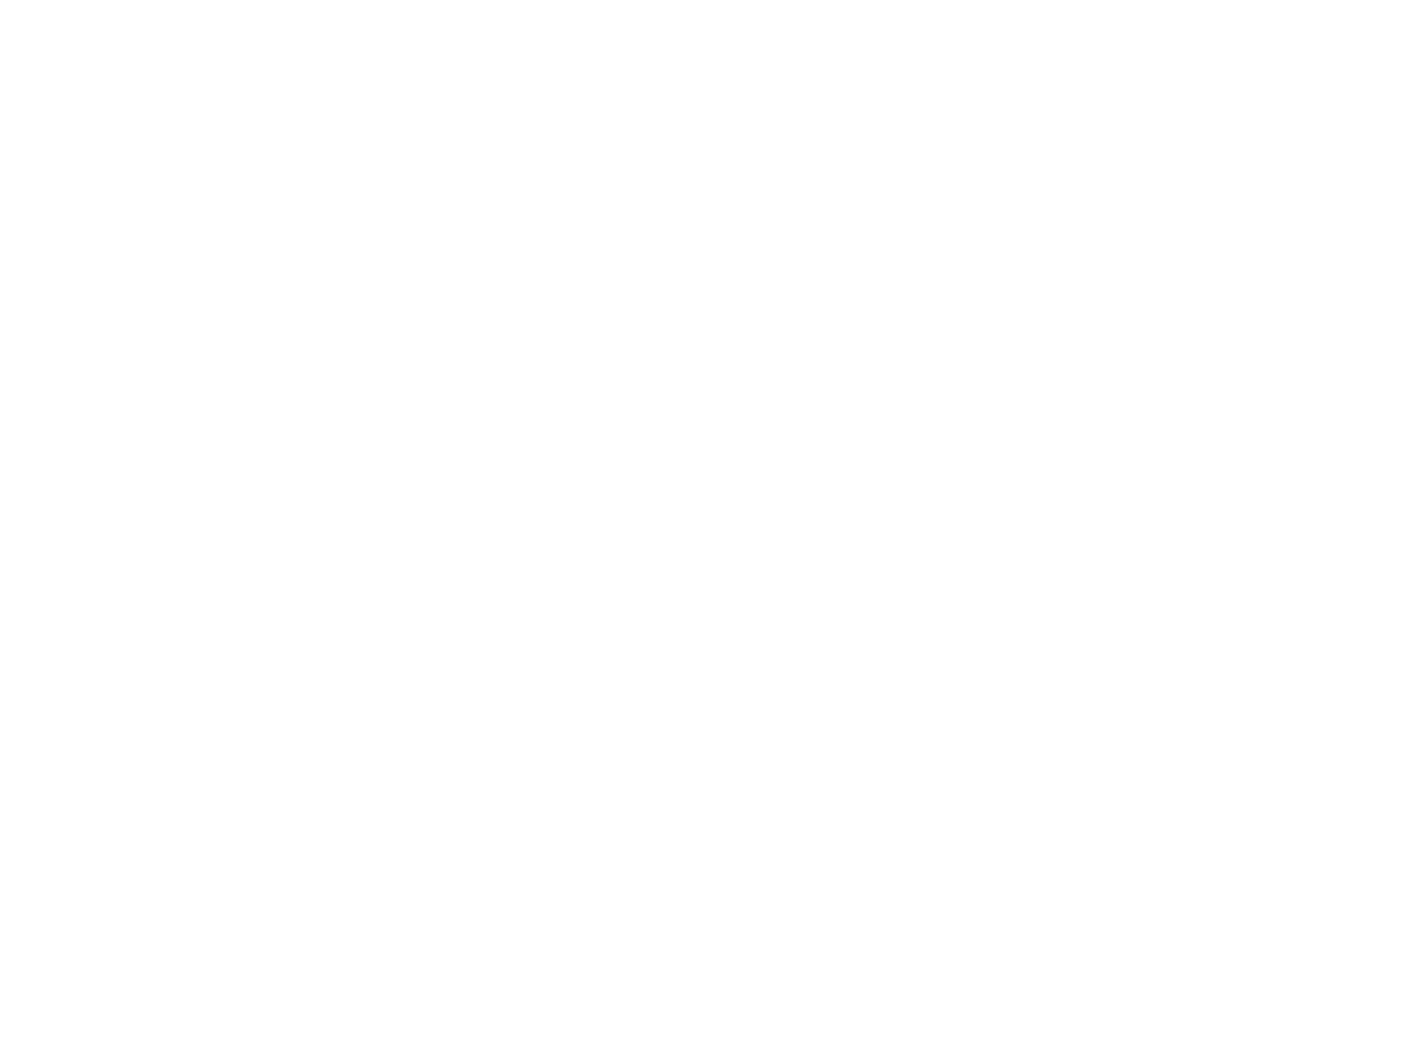

<IPython.core.display.Javascript object>


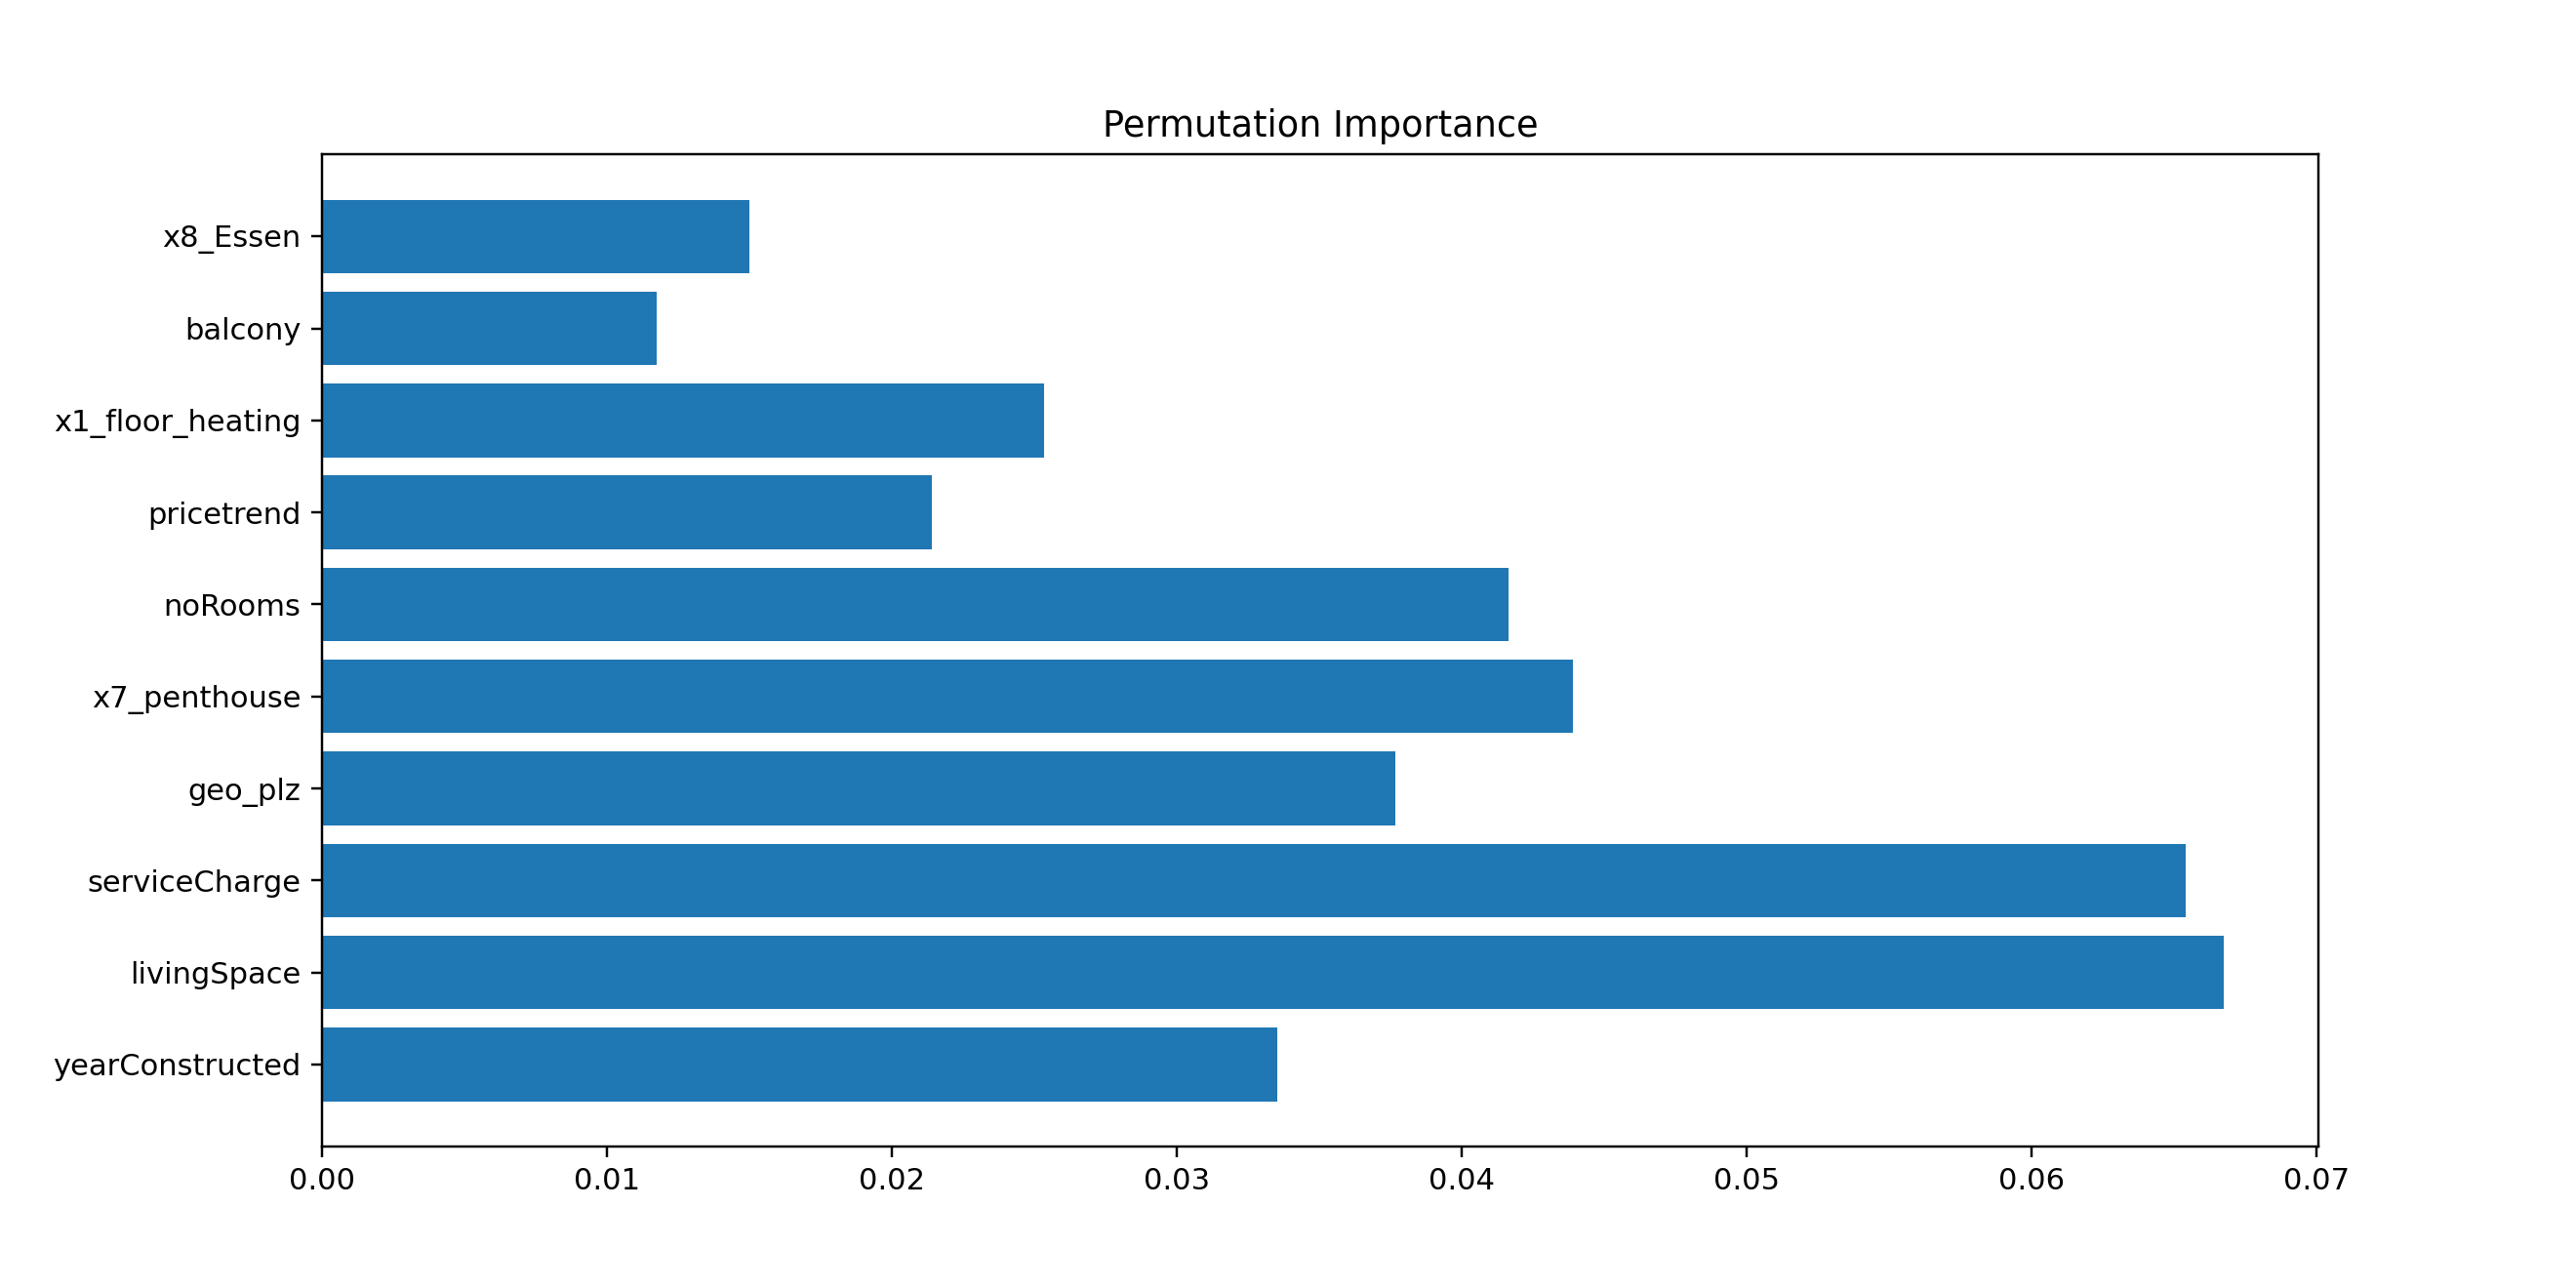

In [ ]:
sorted_idx = data.importances_mean.argsort()[::-1]
#print(result.importances_mean[sorted_idx])

plt.clf()
fig = plt.figure(figsize=(12, 6))
plt.barh(all_attributes[sorted_idx][:10], est.feature_importances_[sorted_idx][:10], align='center')
plt.title('Permutation Importance')
plt.show()

#### Partial Dependency Plot Random Forest with yearConstructed and livingSpace

/opt/anaconda3/envs/ADS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>


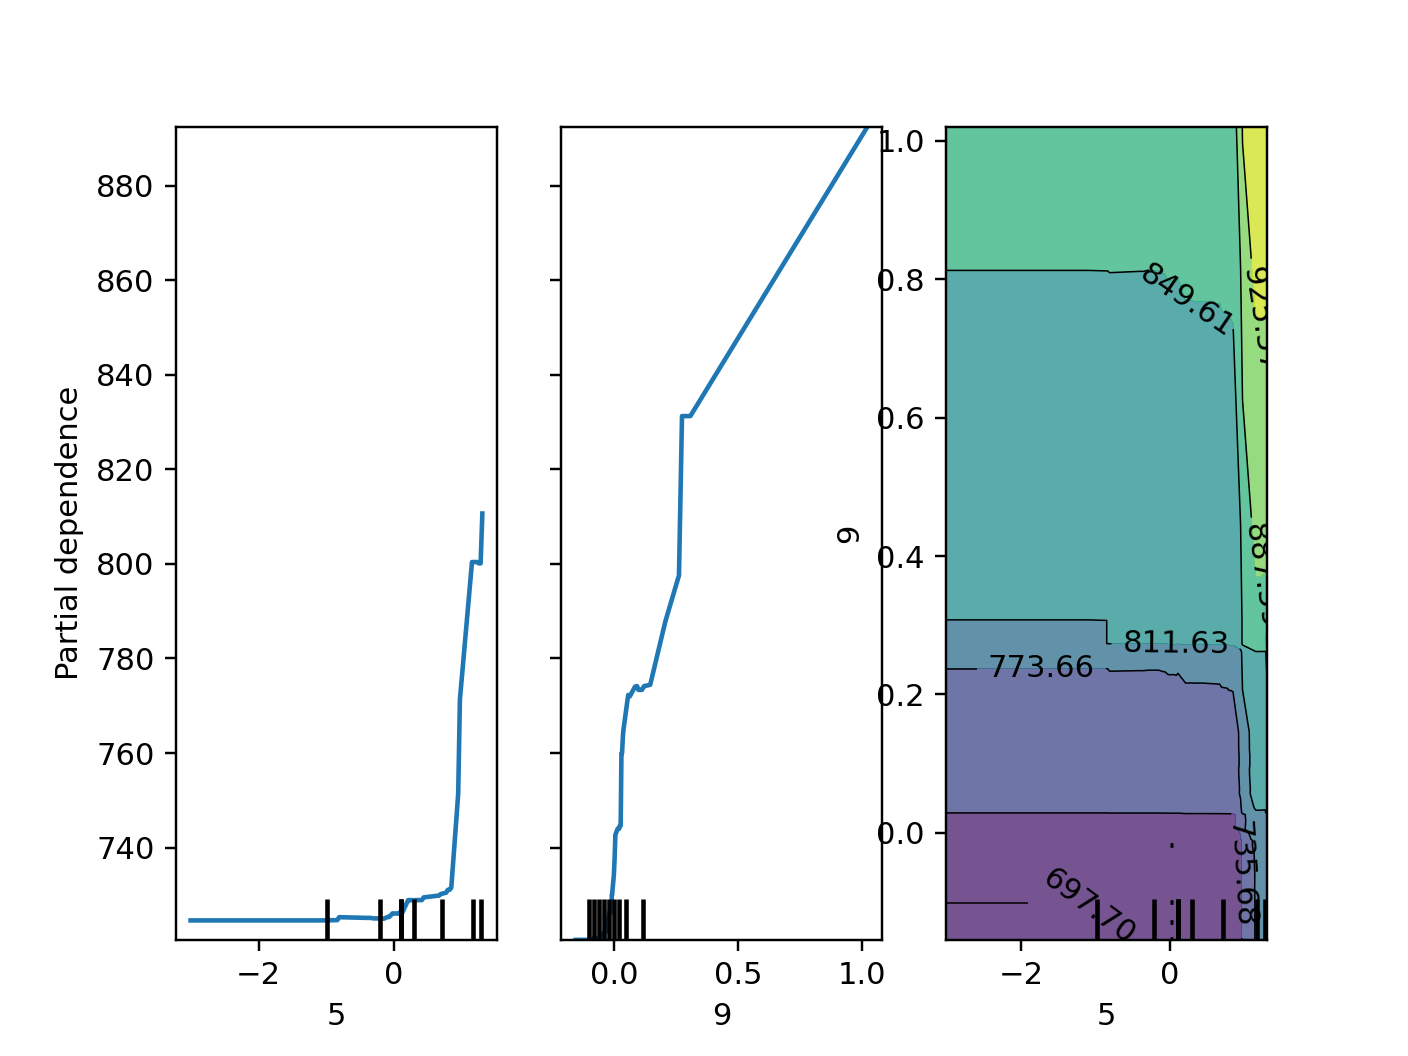

In [ ]:
disp1 = plot_partial_dependence(est, X_red.toarray(),[5, 9,(5,9)]) 

----------

### Predict - Neural Network

In [ ]:
X_train_prepared = X_train_prepared[:((int)(X_train_prepared.shape[0]*0.6))]
y_train = y_train[:((int)(y_train.shape[0]*0.6))]
X_valid_prepared = X_valid_prepared[:((int)(X_valid_prepared.shape[0]*0.6))]
y_valid = y_valid[:((int)(y_valid.shape[0]*0.6))]
X_test_prepared = X_test_prepared[:((int)(X_test_prepared.shape[0]*0.6))]
y_test = y_test[:((int)(y_test.shape[0]*0.6))]

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_6718/3589548168.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train = y_train[:((int)(y_train.shape[0]*0.6))]
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_6718/3589548168.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_valid = y_valid[:((int)(y_valid.shape[0]*0.6))]
/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_6718/3589548168.py:6: FutureWarning: The behavior of `series[i:j]` with

In [ ]:
X_train_prepared = X_train_prepared.toarray()
X_valid_prepared = X_valid_prepared.toarray()
X_test_prepared = X_test_prepared.toarray()

In [ ]:
model = keras.models.Sequential()
input_ = keras.layers.Input(shape=X_train_prepared.shape[1:])
hidden1 = keras.layers.Dense(60,activation="relu")(input_)
hidden2 = keras.layers.Dense(60,activation="relu")(hidden1)
hidden3 = keras.layers.Dense(60,activation="relu")(hidden2)
concat = keras.layers.concatenate([input_, hidden2, hidden3])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_],outputs=[output])

model.compile(loss="mean_absolute_error", optimizer=keras.optimizers.Adam(learning_rate=1e-2))
history = model.fit(X_train_prepared, y_train, epochs=20, validation_data=(X_valid_prepared, y_valid))

Epoch 1/20
3022/3022 [==============================] - 115s 38ms/step - loss: 83.8288 - val_loss: 61.0110
Epoch 2/20
3022/3022 [==============================] - 105s 35ms/step - loss: 64.9260 - val_loss: 54.9730
Epoch 3/20
3022/3022 [==============================] - 117s 39ms/step - loss: 58.5353 - val_loss: 52.4081
Epoch 4/20
3022/3022 [==============================] - 126s 42ms/step - loss: 55.4329 - val_loss: 52.3989
Epoch 5/20
3022/3022 [==============================] - 115s 38ms/step - loss: 52.6676 - val_loss: 52.7217
Epoch 6/20
3022/3022 [==============================] - 100s 33ms/step - loss: 50.7809 - val_loss: 51.1368
Epoch 7/20
3022/3022 [==============================] - 105s 35ms/step - loss: 49.0486 - val_loss: 51.9345
Epoch 8/20
3022/3022 [==============================] - 104s 34ms/step - loss: 47.8611 - val_loss: 50.1595
Epoch 9/20
3022/3022 [==============================] - 2881s 954ms/step - loss: 46.6112 - val_loss: 51.0451
Epoch 10/20
3022/3022 [============

In [ ]:
model.evaluate(X_test_prepared,y_test)

1487/1487 [==============================] - 13s 9ms/step - loss: 83.1180


83.11797332763672

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-2, input_shape=[48661]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_absolute_error", optimizer=optimizer)
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/var/folders/x1/8mvq21453dx722swn08f95280000gn/T/ipykernel_6718/821033986.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [ ]:
param_distribs = {
    "n_hidden": [ 1, 2, 3],
    "n_neurons": np.arange(20, 60).tolist(),
    "learning_rate": reciprocal(1e-2, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=2, verbose=2)
rnd_search_cv.fit(X_train_prepared, y_train, epochs=20,
                  validation_data=(X_valid_prepared, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Epoch 1/20
1511/1511 [==============================] - 49s 32ms/step - loss: 105.2616 - val_loss: 60.0171
Epoch 2/20
1511/1511 [==============================] - 40s 26ms/step - loss: 83.0623 - val_loss: 57.5188
Epoch 3/20
1511/1511 [==============================] - 40s 26ms/step - loss: 75.9257 - val_loss: 67.7597
Epoch 4/20
1511/1511 [==============================] - 36s 24ms/step - loss: 72.5470 - val_loss: 54.2929
Epoch 5/20
1511/1511 [==============================] - 37s 25ms/step - loss: 69.0012 - val_loss: 54.6732
Epoch 6/20
1511/1511 [==============================] - 37s 25ms/step - loss: 66.5284 - val_loss: 58.4782
Epoch 7/20
1511/1511 [==============================] - 37s 25ms/step - loss: 65.4514 - val_loss: 52.7239
Epoch 8/20
1511/1511 [==============================] - 39s 26ms/step - loss: 63.0000 - val_loss: 54.2822
Epoch 9/20
1511/1511 [==============================] - 38s 25ms/step - loss: 61.1829 - va

Epoch 1/20
1511/1511 [==============================] - 29s 19ms/step - loss: 137.0898 - val_loss: 60.9105
Epoch 2/20
1511/1511 [==============================] - 20s 14ms/step - loss: 81.7378 - val_loss: 55.2959
Epoch 3/20
1511/1511 [==============================] - 21s 14ms/step - loss: 74.7229 - val_loss: 55.0370
Epoch 4/20
1511/1511 [==============================] - 21s 14ms/step - loss: 70.7080 - val_loss: 53.4489
Epoch 5/20
1511/1511 [==============================] - 21s 14ms/step - loss: 68.1936 - val_loss: 53.4879
Epoch 6/20
1511/1511 [==============================] - 21s 14ms/step - loss: 66.1265 - val_loss: 53.2874
Epoch 7/20
1511/1511 [==============================] - 22s 14ms/step - loss: 64.4381 - val_loss: 52.9297
Epoch 8/20
1511/1511 [==============================] - 22s 14ms/step - loss: 62.8263 - val_loss: 52.9278
Epoch 9/20
1511/1511 [==============================] - 22s 14ms/step - loss: 61.4688 - val_loss: 53.1590
Epoch 10/20
1511/1511 [======================

Epoch 10/20
1511/1511 [==============================] - 32s 21ms/step - loss: 32.6349 - val_loss: 55.7261
Epoch 11/20
1511/1511 [==============================] - 33s 22ms/step - loss: 31.8248 - val_loss: 54.4728
Epoch 12/20
1511/1511 [==============================] - 32s 21ms/step - loss: 30.3101 - val_loss: 55.9652
Epoch 13/20
1511/1511 [==============================] - 32s 21ms/step - loss: 29.7468 - val_loss: 53.7903
Epoch 14/20
1511/1511 [==============================] - 33s 22ms/step - loss: 28.9552 - val_loss: 54.7959
Epoch 15/20
1511/1511 [==============================] - 33s 22ms/step - loss: 27.9354 - val_loss: 53.4512
Epoch 16/20
1511/1511 [==============================] - 33s 22ms/step - loss: 27.9390 - val_loss: 53.2364
Epoch 17/20
1511/1511 [==============================] - 33s 22ms/step - loss: 26.9526 - val_loss: 58.4398
Epoch 18/20
1511/1511 [==============================] - 33s 22ms/step - loss: 26.9090 - val_loss: 55.5085
Epoch 19/20
1511/1511 [==============

1511/1511 [==============================] - 38s 25ms/step - loss: 55.4398 - val_loss: 51.7508
Epoch 15/20
1511/1511 [==============================] - 38s 25ms/step - loss: 55.3695 - val_loss: 54.2670
Epoch 16/20
1511/1511 [==============================] - 37s 25ms/step - loss: 54.4505 - val_loss: 55.5645
Epoch 17/20
1511/1511 [==============================] - 38s 25ms/step - loss: 53.4846 - val_loss: 54.4124
Epoch 18/20
1511/1511 [==============================] - 38s 25ms/step - loss: 53.6311 - val_loss: 52.9300
Epoch 19/20
1511/1511 [==============================] - 38s 25ms/step - loss: 52.6634 - val_loss: 54.2308
Epoch 20/20
1511/1511 [==============================] - 8s 5ms/step - loss: 51.7543
[CV] END learning_rate=0.013903636663674463, n_hidden=2, n_neurons=55; total time=14.1min
Epoch 1/20
1511/1511 [==============================] - 48s 31ms/step - loss: 78.0533 - val_loss: 68.5410
Epoch 2/20
1511/1511 [==============================] - 36s 24ms/step - loss: 53.4671 - v

RandomizedSearchCV(cv=2,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc72c5a6ef0>,
                   param_distributions={'learning_rate': [0.019077605635364116,
                                                          0.01995560506935283,
                                                          0.02738250018431439,
                                                          0.017024281217175,
                                                          0.013899233745346637,
                                                          0.012138566201138993,
                                                          0.024812615991993085,
                                                          0.02343429279115559,
                                                          0.012843733689296238,
                                                          0.012812440227639981,
                                                          0.01203...
                                                          0.02719084086786695,
                                                          0.010844438008267246,
                                                          0.016901232505621856,
                                                          0.018220310870956137,
                                                          0.025133433556487974,
                                                          0.025112202641804467,
                                                          0.015036456868257464,
                                                          0.02218960082253691,
                                                          0.01903602612704766,
                                                          0.010562940080494026, ...],
                                        'n_hidden': [1, 2, 3],
                                        'n_neurons': [20, 21, 22, 23, 24, 25,
                                                      26, 27, 28, 29, 30, 31,
                                                      32, 33, 34, 35, 36, 37,
                                                      38, 39, 40, 41, 42, 43,
                                                      44, 45, 46, 47, 48, 49, ...]},
                   verbose=2)

In [ ]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)

{'n_neurons': 54, 'n_hidden': 1, 'learning_rate': 0.015795440164259298}
-65.47949409484863


In [ ]:
rnd_search_cv.score(X_test_prepared, y_test)

1487/1487 [==============================] - 7s 5ms/step - loss: 66.5306


-66.53060150146484

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_prepared, y_test)

1487/1487 [==============================] - 7s 4ms/step - loss: 66.5306


66.53060150146484

### Results - Absolute Error

| Method            | Random     | Consecutive |
|-------------------|------------|-------------|
| Linear Regression | <span style="color:blue">154.98</span>|<span style="color:blue">149.90</span>|
| Polynomial Regression | <span style="color:red">180.35</span>|<span style="color:red">203.92</span>|
| Random Forest     | <span style="color:red">241.82</span>|<span style="color:red">223.07</span>|
| Neural Network    | <span style="color:blue">**75.23**</span> |<span style="color:blue">83.11</span> |
| RandomizedSearch NN     | <span style="color:red">147.77</span> |<span style="color:blue">**66.53**</span> |

<span style="color:blue">blue text</span> = full dataset
<span style="color:red">red text</span> = reduced dataset

## Ethical Considerations

Our estimates for a rental price come the data that we have, and some neighborhoods might be underrepresented. More investigation from which areas our data is coming from might be necessary. Are all neighbourhoods equally represented in the initial dataset? 

We might have influenced the data with our own bias in the way we did the data processing, by dropping some of the older houses, or maybe some of the higher end rent.

To get a better perspective our data might have benefitted from adding different data sources (wages, inflation), to have a clear understanding of the prices evolution over time. We saw a clear spike in the February 2020 median rental prices, but were wages and inflation going the same direction or was the real estate market overestimating its value? 

Housing is a necessity for everyone, so people might often not have enough time or resources to find cheaper options.